# Simulating an Atomic Bomb - An Exercise in Neutron Diffusion #

Evan Petrimoulx 

Dr. J. Rau

December 2024

PHYS-3600, Computation Physics Final Project

## Usual Imports: ##

In [53]:
import numba 
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, IntSlider

## Standard Diffusion ##

Diffusion is defined as "the spreading of something more widely". It is used to describe phenomena such as heat emission, solute and solvent interaction, and even the process of breathing. The phenomena can be described mathematically with the following relation: 

$$
    \frac{\partial \phi}{\partial t} = D \nabla^2 \phi
$$

Where $D$ is the diffusion constant. This value tells us how fast the particles are spreading apart or leaving the source. The left side of the equation tells us how the density of the diffusing material changes over time, and the right hand side tells us how the density of the diffusing material changes across space.

If $D$ is a constant throughout the diffusion process, the equation has analytical solutions and is identical to the *Heat Equation*. It has the following solutions in 1-Dimension (Using Dirichlet Boundary Conditions):

$$  
    \phi(x, t) = \sum_{k = 1}^\infty A_k \sin \left( \frac{k \pi x}{l} \right) e^{\frac{-D k^2 \pi^2 t}{l^2}} 
$$

Where $A_k$ is:

$$
    A_k = \frac{2}{l} \int_0^l \phi(x, 0) \sin \left( \frac{k \pi x}{l} \right)dx
$$

Each exponential converges to zero as $t \rightarrow \infty$, which means that $\phi(x, t)$ tends to equillibrium.

But it is important to note that this equation and its solutions only account for diffusing material. What if the material is diffusing, and the diffused material interacts with its surroundings, producing more diffusion? Will the system still reach an equillibrium? Or will it begin to grow exponentially instead?
 
This modified process is known as a **Diffusion-Reaction**. It is common in processes such as atomic bombs and nuclear reactors, where neutrons are diffusing from a fuel source and the produced neutrons interact and produce **more** neutrons. Modifying the standard diffusion equation to fit our neutron-reaction process is of key interest to this project, and will be used to analyze different fissile materials, looking at their energy output. The modified equation can be written as follows:

$$
    \frac{\partial \phi}{\partial t} = D \nabla^2 \phi + \eta \phi
$$

Where $\eta$ is the reaction rate of the system. This equation can be solved analytically, but is dependant on the boundary conditions of the problem and the reaction rate of the material being considered.

The general solution process will be to create an object of type "Material", and give it key information based on the fuel rod parameters. This will include things such as atomic number, size, and shape. We then insert the fuel rod into a 3D grid, and diffuse it with its reaction rate. Placing two fuel rods close to eachother allows them to interact with one another, and increase the amount of neutron production, leading to higher energy output. In the case of an atomic bomb explosion, the fuel rods should be smashed together. This will be done here by simulating the diffusion of two fuel rods at different separation distances, and finding when they explode (When the exponential term switches from decay to growth).




We can start by defining constants for the grid size and diffusion. The grid size is limited by RAM, since the simulation area will be a 3D array evolving in time. Right now DIFFUSION_CONST is the value corresponding to U$^{235}$ and is in units of $m^2/s$. The box length is in terms of meters, and the densities along with Avogadro's Number are used to calculate the density of neutrons in 1 cubic meter of fissile material. Additionally, the neutron energy is included so that we can analyze the energy output of the system.

In [54]:
BOX_LENGTH: int = 42 # [m]
DIFFUSION_CONST: float = 2.34e5 # [1/s]
NEUTRON_ENERGY: float = 2 # [MeV]
MeV_to_J: float = 1.6022e-13 # [MeV/J]
URANIUM_DENSITY: float = 18710.0 # [kg/m^3]
PLUTONIUM_DENSITY: float = 15600.0 # [kg/m^3]
AU_to_Kg: float = 1.6605e-27 # [au/kg]

## Fuel Rod Class ##
Now we will implement the class for the fuel rods. They take arguments of length, width, and height for dimensions, as well as element number, also known as the nuclear charge (Z), and the atomic mass. You can also name the element and give it a density as well as a shape name. The shape name determines the initial conditions imposed on the rod.

The rod can be a few different shapes, but it is quite easy to extend the class to create more shapes as needed. For now, the default shape is a cube, with options of creating a sphere, hemisphere (left or right), triangular prism, and cylinder. I have also created an overload function to give the option to print the object and display useful information.

The initial conditions fill a 3D array with the number of neutrons per cubic meter. This is an accurate representation of the number of neutrons in the fuel rod. The calculation for volume is done via standard formulas shown below:

##### Cube #####
$$
    V = l^3
$$

##### Cylinder #####
$$
    V = \pi r^2 h
$$

##### Sphere #####
$$
    V = \frac{4}{3} \pi r^3
$$

##### Hemisphere #####
$$
    V = \frac{2}{3} \pi r^3
$$

##### Triangular Prism #####
$$
    V = \frac{lw}{2} h
$$

In [55]:
class Shape:
    def __init__(self, length: int, width: int, height: int, name: str, mass: float, element_name: str, element_num: int, density: float):
        self.name: str = name
        self.length: int = length
        self.width: int = width
        self.height: int = height
        self.element: str = element_name
        self.element_num: int = element_num
        self.density: float = density
        self.mass: float = mass * AU_to_Kg

    def __str__(self):
        return (f'Element: {self.element}-{int(self.mass / AU_to_Kg)}\n'
                f'Z: {self.element_num}\n'
                f'ρ: {self.density} kg/m^3\n'
                f'M: {self.mass:.2e} kg\n'
                f'Shape: {self.name}\n'
                f'Length: {self.length}m\n'
                f'Width: {self.width}m\n'
                f'Height: {self.height}m')

    def calc_num_neutrons(self):
        return (self.mass / AU_to_Kg) - self.element_num

    def set_initial_conditions(self):
        initial_condition = np.zeros((self.length, self.width, self.height))

        if self.name == "Cylinder":
            cylinder_radius = 3  # Radius of the cylinder
            volume = np.pi * cylinder_radius / self.height
            cylinder_center = (self.length // 2, self.width // 2)  # Center of the cylinder in the XY plane
            cylinder_axis = 'z'  # Axis of the cylinder ('x', 'y', or 'z')

            # Fill the cylinder within the cube
            for x in range(self.length):
                for y in range(self.width):
                    for z in range(self.height):
                        if cylinder_axis == 'z':  # Cylinder aligned along the z-axis
                            distance = np.sqrt((x - cylinder_center[0]) ** 2 + (y - cylinder_center[1]) ** 2)
                            if distance <= cylinder_radius and z < self.height:
                                initial_condition[x, y, z] = self.density * volume * self.calc_num_neutrons() / self.mass

        elif self.name == "Sphere":
            radius = 3
            volume = 4/3 * np.pi * radius**3
            x0, y0, z0 = int(np.floor(initial_condition.shape[0] / 2)), int(np.floor(initial_condition.shape[1] / 2)), int(np.floor(initial_condition.shape[2] / 2))
            for x in range(x0 - radius, x0 + radius + 1):
                for y in range(y0 - radius, y0 + radius + 1):
                    for z in range(z0 - radius, z0 + radius + 1):
                        ''' deb: measures how far a coordinate in A is far from the center. 
                                deb>=0: inside the sphere.
                                deb<0: outside the sphere.'''
                        deb = radius - abs(x0 - x) - abs(y0 - y) - abs(z0 - z)
                        if deb >= 0:
                            initial_condition[x, y, z] = self.density * volume * self.calc_num_neutrons() / self.mass

        elif self.name == "Triangular Prism":
            volume = self.length * self.width / 2 * self.height
            for x in range(0, self.length):
                for y in range(x, self.width):
                    for z in range(y, self.height):
                        initial_condition[x, y, z] = self.density * volume * self.calc_num_neutrons() / self.mass

        elif self.name == "Left Hemisphere":
            radius = 3
            volume = 2 / 3 * np.pi * radius**3 
            x0, y0, z0 = int(np.floor(initial_condition.shape[0] / 2)), int(
                np.floor(initial_condition.shape[1] / 2)), int(np.floor(initial_condition.shape[2] / 2))
            for x in range(x0 - radius, x0 + radius + 1):
                for y in range(y0 - radius, y0 + radius + 1):
                    for z in range(z0 - radius, z0 + radius + 1):
                        deb = radius - abs(x0 - x) - abs(y0 - y) - abs(z0 - z)
                        if deb >= 0:
                            initial_condition[x, y, z] = self.density * volume * self.calc_num_neutrons() / self.mass
            initial_condition[:, :, self.height // 2:] = 0.0

        elif self.name == "Right Hemisphere":
            radius = 3
            volume = 2 / 3 * np.pi * radius**3 
            x0, y0, z0 = int(np.floor(initial_condition.shape[0] / 2)), int(
                np.floor(initial_condition.shape[1] / 2)), int(np.floor(initial_condition.shape[2] / 2))
            for x in range(x0 - radius, x0 + radius + 1):
                for y in range(y0 - radius, y0 + radius + 1):
                    for z in range(z0 - radius, z0 + radius + 1):
                        deb = radius - abs(x0 - x) - abs(y0 - y) - abs(z0 - z)
                        if deb >= 0:
                            initial_condition[x, y, z] = self.density * volume * self.calc_num_neutrons() / self.mass

            initial_condition[:, :, :self.height // 2] = 0.0

        else:
            volume = self.length * self.width * self.height
            initial_condition.fill(self.density * volume * self.calc_num_neutrons() / self.mass)

        return initial_condition

We will now build the 3D diffusion-reaction equation based on the 2D standard diffusion equation discussed in class. The function has arguments for the initial condition, which states the fuel rod positions and their starting neutron densities, the grid spacing, timestep, number of timesteps and boundary conditions for the edges of the simulation grid, which ensure neutrons do not escape. Additionally, I have designed the program to optionally take arguments for the diffusion constant, reaction rate, and boundary conditions. It is mathematically described by

$$
     \frac{\partial \phi}{\partial t} = D \nabla^2 \phi + \eta \phi
$$

It is important to note one key implementation of this algorithm. The arrays passed in to the diffusion_3d function have multiple points with initial conditions. The program then does not know that they are part of a bigger fuel rod system, and treats them as point sources that are very close together and diffuse. They then react with eachother and go super-critical. Since this is not what we want to model, we need to find a way to treat them as a group of initial conditions that diffuse away from their main mass. An easy way to do this is to combine the initial conditions to a central point within the shape. This method was not used however since we wish to model how the shapes of the fuel rods can affect the output. We then instead impose a condition on the system where only the flux from the left rod can react with the flux coming from the right rod. The diffusion part of the equation still happens everywhere, but the reaction section is restricted to only the diffused particles that are travelling in the direction towards the other fuel rod. This ensures that only the neutrons from opposing sources can react together and produce more neutrons. At large separation distances, we should see that the reaction is smaller, while at shorter separation distances, more flux reaches the other rod, and the reaction should be more violent.

The main implementation uses a 3D stencil, which is modelled by the following equation:
$$
    \nabla^2 \phi_{i,j,k} = \frac{1}{\delta x^2} \left( \phi_{i+1, j, k} + \phi_{i - 1, j, k} + \phi_{i, j+1, k} + \phi_{i, j-1, k} + \phi_{i,j,k+1} + \phi_{i,j,k-1} - 6 \phi_{i,j,k}\right)
$$

In [56]:
@numba.njit
def diffusion_3d(
        init_condition: np.ndarray,
        grid_spacing: float,
        timestep: float,
        num_timesteps: int,
        boundary: np.ndarray,
        dirichlet_values: np.ndarray = None,
        boundary_type: str = 'dirichlet',
        diffusion_const: float = 2.34e5,
        reaction_rate: float = 1.896e8
) -> np.ndarray:
    """
    Simulates the 3D diffusion-reaction process over a grid with Dirichlet or Neumann boundary conditions.
    This function evolves the neutron density `n` over time according to the diffusion-reaction equation:
        ∂n/∂t = D ∇²n + ηn
    where `D` is the diffusion constant, and η is the reaction rate constant.
    
    :param init_condition: Initial neutron density array (3D ndarray).
    :type init_condition: numpy.ndarray
    :param grid_spacing: Distance between grid points in the spatial domain.
    :type grid_spacing: float
    :param timestep: Time increment for each simulation step.
    :type timestep: float
    :param num_timesteps: Number of timesteps to simulate.
    :type num_timesteps: int
    :param boundary: Boolean 3D array marking boundary (`True`) and interior (`False`) points.
    :type boundary: numpy.ndarray
    :param dirichlet_values: Fixed concentration values at boundary points (for Dirichlet conditions).
                             If `None`, Neumann (no-flux) conditions are applied.
    :type dirichlet_values: numpy.ndarray, optional
    :param boundary_type: Type of boundary conditions.
    :type boundary_type: str
    :param diffusion_const: Diffusion constant `D`. Default is 2.34e5.
    :type diffusion_const: float, optional
    :param reaction_rate: Reaction rate constant `η`. Default is 1.896e8.
    :type reaction_rate: float, optional
    :return: 4D array of neutron density values over time with shape `(x, y, z, time)`.
    :rtype: numpy.ndarray
    :behavior:
      - Applies periodic boundaries with modular indexing.
      - Dirichlet boundary conditions are used if `dirichlet_values` is provided;
        otherwise, Neumann (no-flux) conditions are applied, keeping boundary values constant.
        
    :author: Evan Petrimoulx
    :date: November 4th 2024
    
    **Example usage:**
    .. code-block:: python
        nx, ny, nz = 10, 10, 10
        init_condition = np.random.rand(nx, ny, nz)
        boundary = np.zeros((nx, ny, nz), dtype=bool)
        boundary[:, 0, :] = boundary[:, -1, :] = True
        result = diffusion_3d(
            init_condition, boundary, grid_spacing=1.0, timestep=0.01, num_timesteps=100
        )
    """

    nx, ny, nz = init_condition.shape

    diffusion: np.ndarray = np.zeros((nx, ny, nz, num_timesteps), dtype=np.float64)
    d = diffusion_const * timestep / grid_spacing**2

    diffusion[:, :, :, 0] = np.copy(init_condition)

    for it in range(1, num_timesteps):
        for ix in range(0, nx):
            for iy in range(0, ny):     
                for iz in range(0, nz):
                    if not boundary[ix, iy, iz]:
                        if (ix < nx // 2 + 3) and (ix > nx // 2 - 3):
                            diffusion[ix, iy, iz, it] = (diffusion[ix, iy, iz, it - 1] + 0.25 * d * (
                                    diffusion[(ix + 1) % nx, iy, iz, it - 1] +
                                    diffusion[(ix - 1) % nx, iy, iz, it - 1] +
                                    diffusion[ix, (iy + 1) % ny, iz, it - 1] +
                                    diffusion[ix, (iy - 1) % ny, iz, it - 1] +
                                    diffusion[ix, iy, (iz + 1) % nz, it - 1] +
                                    diffusion[ix, iy, (iz - 1) % nz, it - 1] - 6 * diffusion[ix, iy, iz, it - 1]) +
                                    reaction_rate * diffusion[ix, iy, iz, it - 1] * timestep)
                        else:
                            diffusion[ix, iy, iz, it] = (diffusion[ix, iy, iz, it - 1] + 0.25 * d * (
                                    diffusion[(ix + 1) % nx, iy, iz, it - 1] +
                                    diffusion[(ix - 1) % nx, iy, iz, it - 1] +
                                    diffusion[ix, (iy + 1) % ny, iz, it - 1] +
                                    diffusion[ix, (iy - 1) % ny, iz, it - 1] +
                                    diffusion[ix, iy, (iz + 1) % nz, it - 1] +
                                    diffusion[ix, iy, (iz - 1) % nz, it - 1] - 6 * diffusion[ix, iy, iz, it - 1]))

                    else:
                        # Neumann Boundary Conditions (zero flux)
                        if boundary_type == 'neumann':
                            if ix == 0:
                                diffusion[ix, iy, iz, it] = diffusion[ix + 1, iy, iz, it - 1]
                            elif ix == nx - 1:
                                diffusion[ix, iy, iz, it] = diffusion[ix - 1, iy, iz, it - 1]
                            if iy == 0:
                                diffusion[ix, iy, iz, it] = diffusion[ix, iy + 1, iz, it - 1]
                            elif iy == ny - 1:
                                diffusion[ix, iy, iz, it] = diffusion[ix, iy - 1, iz, it - 1]
                            if iz == 0:
                                diffusion[ix, iy, iz, it] = diffusion[ix, iy, iz + 1, it - 1]
                            elif iz == nz - 1:
                                diffusion[ix, iy, iz, it] = diffusion[ix, iy, iz - 1, it - 1]

                        # Dirichlet Boundary Conditions
                        elif boundary_type == 'dirichlet' and dirichlet_values is not None:
                            diffusion[ix, iy, iz, it] = dirichlet_values[ix, iy, iz]

                        else:
                            # Robin Boundary Conditions Here
                            diffusion[ix, iy, iz, it] = diffusion[ix, iy, iz, it - 1]
    return diffusion

It is also helpful to define some graphing routines. Since these will be called upon multiple times, I have defined it as a function at the top of the project. This graph will map the fuel rods in 3D space and provide a visual on the objects shapes, as well as their starting location in the grid.

In [57]:
def plot_fuel_rod_positions(array):
    # Get coordinates where the array is True
    x, y, z = np.where(array != 0)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Clear previous plot data
    ax.cla()

    # Plot the cubes as red points
    ax.scatter(x, y, z, c='r', marker='o')

    # Set limits for axes based on the grid size
    ax.set_xlim([0, array.shape[0] - 1])
    ax.set_ylim([0, array.shape[1] - 1])
    ax.set_zlim([0, array.shape[2] - 1])

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Fuel Rod Positions')

    # Optionally add a grid for better spatial orientation
    ax.grid(True)
    plt.show()

Here I define a function to place the fuel rods into the 3D mesh. It takes both fuel rods as inputs, and a separation distance between them. The separation distance determines how far away the fuel rods are away from one another at simulation time.

In [58]:
def place_fuel_rods_in_grid(grid: np.ndarray[float], rod1_initial_condition: np.ndarray[float], rod2_initial_condition: np.ndarray[float ], separation: float) -> np.ndarray[float]:
    """
    Takes the initial conditions set up from the individual fuel rods and places them into the simulation grid at a
    specified separation from one another

    :param grid: The Simulation grid
    :type grid: np.ndarray[float]
    :param rod1_initial_condition: The first fuel rod initial conditions (initial neutron density)
    :type rod1_initial_condition: np.ndarray
    :type rod2_initial_condition: np.ndarray
    :param rod2_initial_condition: The second fuel rod initial conditions (initial neutron density)
    :param separation: The separation between the fuel rods and the initial conditions
    :type separation: float
    """

    # Get the size of the larger and smaller arrays
    larger_size = grid.shape
    smaller_size1 = rod1_initial_condition.shape
    smaller_size2 = rod2_initial_condition.shape

    # Calculate the center of the larger array
    center_larger_x, center_larger_y, center_larger_z = larger_size[0] // 2, larger_size[1] // 2, larger_size[2] // 2

    # Calculate the starting indices for placing the smaller first array
    start_x = center_larger_x - smaller_size1[0] // 2 + separation //2
    start_y = center_larger_y - smaller_size1[1] // 2
    start_z = center_larger_z - smaller_size1[2] // 2

    # Place the smaller array inside the larger one
    grid[start_x:start_x + smaller_size1[0], start_y:start_y + smaller_size1[1], start_z:start_z + smaller_size1[2]] = rod1_initial_condition

    # Calculate the starting indices for placing the second smaller array
    start_x = center_larger_x - smaller_size2[0] // 2 - separation//2
    start_y = center_larger_y - smaller_size2[1] // 2
    start_z = center_larger_z - smaller_size2[2] // 2

    grid[start_x:start_x + smaller_size2[0], start_y:start_y + smaller_size2[1],start_z:start_z + smaller_size2[2]] = rod2_initial_condition

    return grid

A simple function to calculate the growth rate of neutrons in the system is also helpful in order to test criticality.

In [59]:
def growth_rate(total_density: np.ndarray) -> np.ndarray:
    """
    Determines the growth rate of neutrons in the diffusion process. If the Neutron Multiplication factor (k) is
        equal to 1, The reaction is critical. If k is less than 1 the reaction is Sub-critical, and if k is greater than 1 the
        reaction is Supercritical

    :param total_density:
    :type: np.ndarray

    :return: average neutron multiplication factor
    :rtype np.ndarray

    :author: Evan Petrimoulx
    :date: November 5th 2024
    """
    k_effective = np.zeros(len(total_density))
    for i in range(1, len(total_density) - 1):
        k_effective[i+1] =  total_density[i+1] / total_density[i]

    return k_effective

def determine_k(k) -> None:
    if k > 1:
        print(f'The reaction has gone super-critical!')
    elif k == 1:
        print(f'The reaction has gone critical!')
    else:
        print(f'The reaction is sub-critical!')

For insightful visuals, as well as a bit of fun, I have implemented an interactive widget for a 2D image slice of the simulation. You can look at the diffusion across the x-z plane, while sliding across the y-axis as well as the time axis.

In [60]:
def plot_diffusion(time_step, y_index):
    """Plot a 2D slice of the 3D diffusion result at a specific time step."""
    plt.figure(figsize=(8, 6))
    
    # Create the imshow plot and store the return object
    im = plt.imshow(
        np.transpose(result[:, y_index, :, time_step]),
        cmap='coolwarm',
        origin='lower',
        vmin=0.0,
        vmax=3e33
    )
    
    # Add contour on top of the image
    plt.contour(
        np.transpose(result[:, y_index, :, time_step]),
        levels=30,
        linewidths=0.5,
        colors='k',
        alpha=0.5
    )
    
    # Use the imshow object to add the color bar
    plt.colorbar(im, fraction=0.02)
    
    plt.title(f"Diffusion at step {time_step}")
    plt.xlabel("X-axis")
    plt.ylabel("Z-axis")
    plt.show()

The energy will also be important in order to figure out how much energy is released in the event of an explosion. Since the neutron energy is given in MeV, a conversion rate is applied to convert to Joules.

In [61]:
def get_energy(density: np.ndarray[float]) -> None:
    energy_init = density[0] * NEUTRON_ENERGY * MeV_to_J
    energy_final = density[-1] * NEUTRON_ENERGY * MeV_to_J
    print(f'\nThe energy in the system initially is {energy_init:.3e} J')
    print(f'The energy in the system at the end of the simulation is {energy_final:.3e} J\n')
    print(f'The energy emitted/lost was {energy_final - energy_init:.2e} J')
    

Below is where the main implementation begins, we start with two cubes of Uranium-235, starting as far apart as possible. 

In [62]:
# Create Fuel Rod Objects
fuel_rod_1 = Shape(8, 8, 8, 'Cube', 235, 'Uranium', 92, URANIUM_DENSITY)
fuel_rod_2 = Shape(8, 8, 8, 'Cube', 235, 'Uranium', 92, URANIUM_DENSITY)

print(f'{fuel_rod_1} \n')
print(f'{fuel_rod_2} \n')

# Set separation distance
object_separation = 30

Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 

Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 



Here we set the initial conditions, as well as set up the grid spacing. We also determing the CHF values for stability with the following relation:

$$
    \delta t \le \frac{\delta x^2}{6 D}
$$

The 6 comes from the 6 point stencil that I am implementing. I also then divide this value by 4 to ensure that we as stable as possible.

In [63]:
# Set up initial conditions for both Fuel Rod Objects
initial_condition_1 = fuel_rod_1.set_initial_conditions()
initial_condition_2 = fuel_rod_2.set_initial_conditions()

# Initialize grid-spacing, timesteps, number of timesteps, total time, and density
grid_spacing: float       = 1 / BOX_LENGTH
timestep_size: float      = (grid_spacing ** 2 / 6 / DIFFUSION_CONST) * 0.25
t_final: float            = 5e-8
num_timesteps: int        = int(t_final / timestep_size)
total_density: np.ndarray = np.zeros(num_timesteps)
time: np.ndarray          = np.linspace(0, t_final, num_timesteps)

Now we create the grid, place the fuel rods into the grid, and then set the boundary conditions.

In [64]:
# Create Grid
grid = np.zeros((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH))

# Embed fuel rods into the grid
grid = place_fuel_rods_in_grid(grid, initial_condition_1, initial_condition_2, object_separation)

# Set up boundary conditions
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
boundary_grid[-1, :, :] = True
boundary_grid[:, -1, :] = True
boundary_grid[0, :, :] = True
boundary_grid[:, 0, :] = True

Next, I plot the positions of the fuel rods and calculate the diffusion, making sure to check for any overflow values or NaN's throughout the process. After the diffusion is calculated I calculate the density of neutrons at each spatial step and use the information to determine the criticality status $k$.

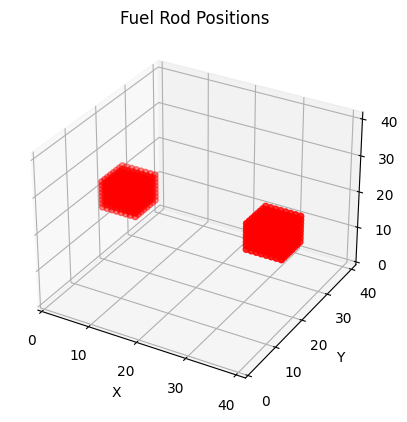

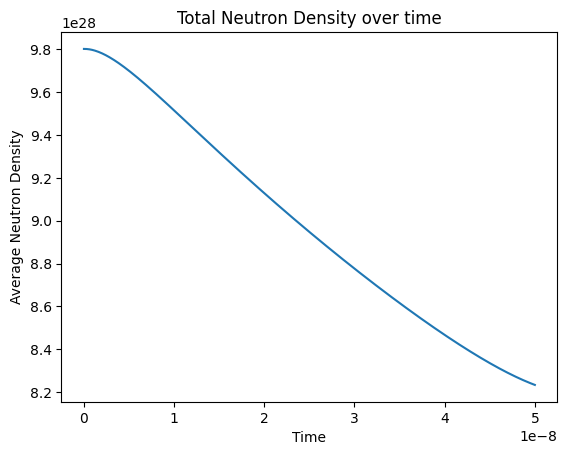

In [65]:
# Plot the fuel rod starting positions
plot_fuel_rod_positions(grid)

# Diffuse
result = diffusion_3d(grid, grid_spacing, timestep_size, num_timesteps, boundary_grid)

# Check for nan's
if np.isnan(result).any():
    print(f'The reaction went super critical and an overflow occurred. Stopping the simulation.')
    exit()
    
# Calculate density
for i in range(0, num_timesteps):
    total_density[i] = np.sum(result[:, :, :, i]) / result.size

plt.figure()
plt.title(f'Total Neutron Density over time')
plt.xlabel('Time')
plt.ylabel('Average Neutron Density')
plt.plot(time, total_density)
plt.show()

Finally, I plot the diffusion densities across 3D space and time, using 2 interactive sliders.

In [66]:
# Create the slider widget for time step
time_slider = IntSlider(
    value=0,  # Initial value
    min=0,  # Minimum time step
    max=result.shape[3] - 1,  # Maximum time step
    step=1,  # Increment step
    description='Time Step'
)

y_slider = IntSlider(
    value= result.shape[1] // 2,
    min=0,
    max= result.shape[1] - 1,
    step = 1,
    description='Y-axis'
)

# Use the interact function to link the slider to the plot function
interact(plot_diffusion, time_step=time_slider, y_index=y_slider)

interactive(children=(IntSlider(value=0, description='Time Step', max=494), IntSlider(value=21, description='Y…

<function __main__.plot_diffusion(time_step, y_index)>

Here I use the density to find $k$, and also calculate the amount of energy emitted in the reaction.

In [67]:
k = growth_rate(total_density)
determine_k(k[0])
determine_k(k[-1])

get_energy(total_density)

The reaction is sub-critical!
The reaction is sub-critical!

The energy in the system initially is 3.141e+16 J
The energy in the system at the end of the simulation is 2.638e+16 J

The energy emitted/lost was -5.03e+15 J


Now analyzing when the rods are closer together:

Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 

Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 



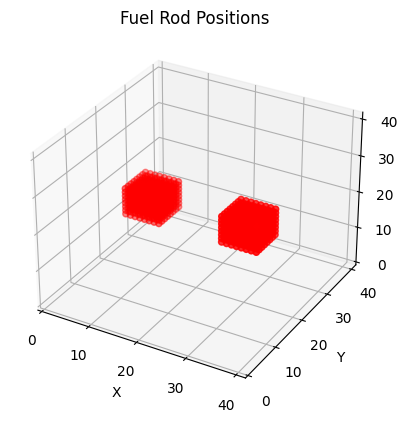

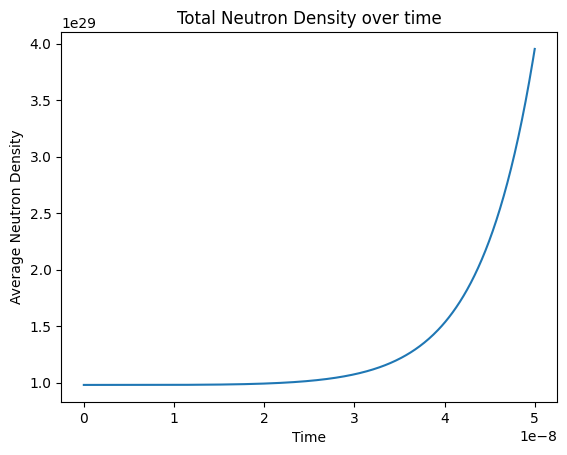

interactive(children=(IntSlider(value=0, description='Time Step', max=494), IntSlider(value=21, description='Y…

<function __main__.plot_diffusion(time_step, y_index)>

In [68]:
# Create Fuel Rod Objects
fuel_rod_1 = Shape(8, 8, 8, 'Cube', 235, 'Uranium', 92, URANIUM_DENSITY)
fuel_rod_2 = Shape(8, 8, 8, 'Cube', 235, 'Uranium', 92, URANIUM_DENSITY)

print(f'{fuel_rod_1} \n')
print(f'{fuel_rod_2} \n')

# Set up initial conditions for both Fuel Rod Objects
initial_condition_1 = fuel_rod_1.set_initial_conditions()
initial_condition_2 = fuel_rod_2.set_initial_conditions()

# Initialize grid-spacing, timesteps, number of timesteps, total time, and density
grid_spacing: float       = 1 / BOX_LENGTH
timestep_size: float      = (grid_spacing ** 2 / 6 / DIFFUSION_CONST) * 0.25
t_final: float            = 5e-8
num_timesteps: int        = int(t_final / timestep_size)
total_density: np.ndarray = np.zeros(num_timesteps)
time: np.ndarray          = np.linspace(0, t_final, num_timesteps)

# Create Grid
grid = np.zeros((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH))
object_separation = 20

# Embed fuel rods into the grid
grid = place_fuel_rods_in_grid(grid, initial_condition_1, initial_condition_2, object_separation)

# Set up boundary conditions
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
boundary_grid[-1, :, :] = True
boundary_grid[:, -1, :] = True
boundary_grid[0, :, :] = True
boundary_grid[:, 0, :] = True


# Plot the fuel rod starting positions
plot_fuel_rod_positions(grid)

# Diffuse
result = diffusion_3d(grid, grid_spacing, timestep_size, num_timesteps, boundary_grid)

# Check for nan's
if np.isnan(result).any():
    print(f'The reaction went super critical and an overflow occurred. Stopping the simulation.')
    exit()
    
# Calculate density
for i in range(0, num_timesteps):
    total_density[i] = np.sum(result[:, :, :, i]) / result.size

plt.figure()
plt.title(f'Total Neutron Density over time')
plt.xlabel('Time')
plt.ylabel('Average Neutron Density')
plt.plot(time, total_density)
plt.show()

# Create the slider widget for time step
time_slider = IntSlider(
    value=0,  # Initial value
    min=0,  # Minimum time step
    max=result.shape[3] - 1,  # Maximum time step
    step=1,  # Increment step
    description='Time Step'
)

y_slider = IntSlider(
    value= result.shape[1] // 2,
    min=0,
    max= result.shape[1] - 1,
    step = 1,
    description='Y-axis'
)

# Use the interact function to link the slider to the plot function
interact(plot_diffusion, time_step=time_slider, y_index=y_slider)

In [69]:
k = growth_rate(total_density)
determine_k(k[0])
determine_k(k[-1])

get_energy(total_density)

The reaction is sub-critical!
The reaction has gone super-critical!

The energy in the system initially is 3.141e+16 J
The energy in the system at the end of the simulation is 1.267e+17 J

The energy emitted/lost was 9.52e+16 J


Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 

Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 



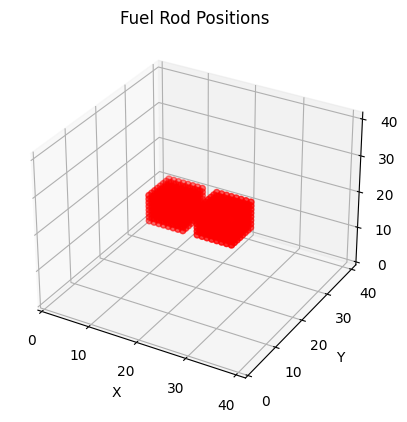

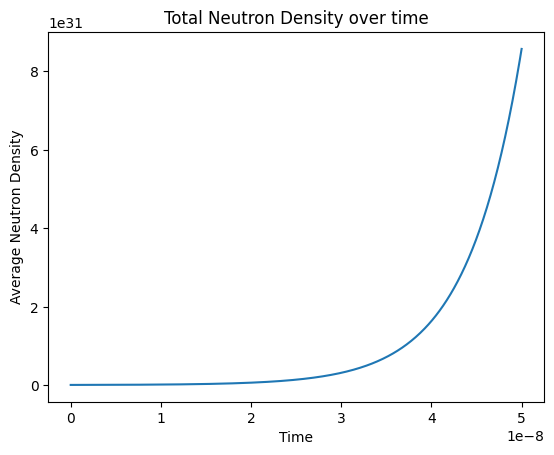

interactive(children=(IntSlider(value=0, description='Time Step', max=494), IntSlider(value=21, description='Y…

<function __main__.plot_diffusion(time_step, y_index)>

In [70]:
# Create Fuel Rod Objects
fuel_rod_1 = Shape(8, 8, 8, 'Cube', 235, 'Uranium', 92, URANIUM_DENSITY)
fuel_rod_2 = Shape(8, 8, 8, 'Cube', 235, 'Uranium', 92, URANIUM_DENSITY)

print(f'{fuel_rod_1} \n')
print(f'{fuel_rod_2} \n')

# Set up initial conditions for both Fuel Rod Objects
initial_condition_1 = fuel_rod_1.set_initial_conditions()
initial_condition_2 = fuel_rod_2.set_initial_conditions()

# Initialize grid-spacing, timesteps, number of timesteps, total time, and density
grid_spacing: float       = 1 / BOX_LENGTH
timestep_size: float      = (grid_spacing ** 2 / 6 / DIFFUSION_CONST) * 0.25
t_final: float            = 5e-8
num_timesteps: int        = int(t_final / timestep_size)
total_density: np.ndarray = np.zeros(num_timesteps)
time: np.ndarray          = np.linspace(0, t_final, num_timesteps)

# Create Grid
grid = np.zeros((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH))
object_separation = 10

# Embed fuel rods into the grid
grid = place_fuel_rods_in_grid(grid, initial_condition_1, initial_condition_2, object_separation)

# Set up boundary conditions
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
boundary_grid[-1, :, :] = True
boundary_grid[:, -1, :] = True
boundary_grid[0, :, :] = True
boundary_grid[:, 0, :] = True

# Plot the fuel rod starting positions
plot_fuel_rod_positions(grid)

# Diffuse
result = diffusion_3d(grid, grid_spacing, timestep_size, num_timesteps, boundary_grid)

# Check for nan's
if np.isnan(result).any():
    print(f'The reaction went super critical and an overflow occurred. Stopping the simulation.')
    exit()
    
# Calculate density
for i in range(0, num_timesteps):
    total_density[i] = np.sum(result[:, :, :, i]) / result.size

plt.figure()
plt.title(f'Total Neutron Density over time')
plt.xlabel('Time')
plt.ylabel('Average Neutron Density')
plt.plot(time, total_density)
plt.show()

# Create the slider widget for time step
time_slider = IntSlider(
    value=0,  # Initial value
    min=0,  # Minimum time step
    max=result.shape[3] - 1,  # Maximum time step
    step=1,  # Increment step
    description='Time Step'
)

y_slider = IntSlider(
    value= result.shape[1] // 2,
    min=0,
    max= result.shape[1] - 1,
    step = 1,
    description='Y-axis'
)

# Use the interact function to link the slider to the plot function
interact(plot_diffusion, time_step=time_slider, y_index=y_slider)

In [71]:
k = growth_rate(total_density)
determine_k(k[0])
determine_k(k[-1])

get_energy(total_density)

The reaction is sub-critical!
The reaction has gone super-critical!

The energy in the system initially is 3.141e+16 J
The energy in the system at the end of the simulation is 2.747e+19 J

The energy emitted/lost was 2.74e+19 J


We can also mix and match the shapes to create a more interesting simulation. Lets start with a Left-hemisphere and a cube:

Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Left Hemisphere
Length: 8m
Width: 8m
Height: 8m 

Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Sphere
Length: 8m
Width: 8m
Height: 8m 



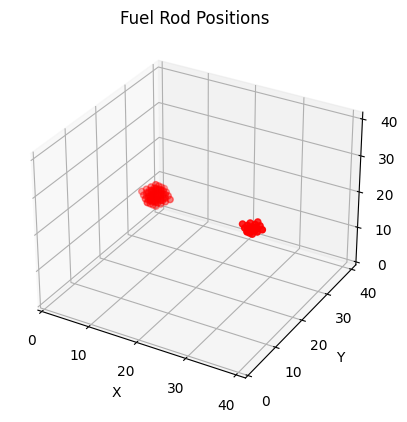

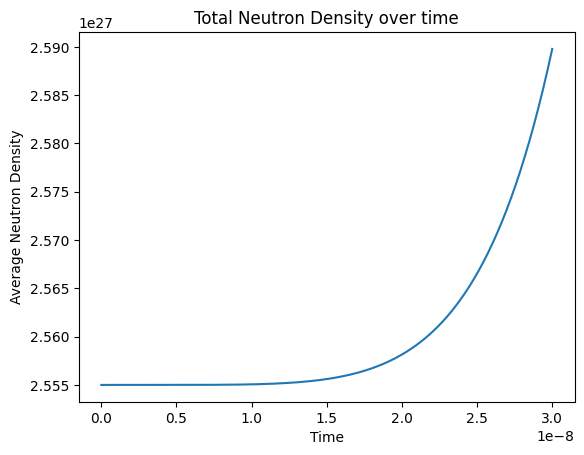

interactive(children=(IntSlider(value=0, description='Time Step', max=296), IntSlider(value=21, description='Y…

<function __main__.plot_diffusion(time_step, y_index)>

In [72]:
# Create Fuel Rod Objects
fuel_rod_1 = Shape(8, 8, 8, 'Left Hemisphere', 235, 'Uranium', 92, URANIUM_DENSITY)
fuel_rod_2 = Shape(8, 8, 8, 'Sphere', 235, 'Uranium', 92, URANIUM_DENSITY)

print(f'{fuel_rod_1} \n')
print(f'{fuel_rod_2} \n')

# Set up initial conditions for both Fuel Rod Objects
initial_condition_1 = fuel_rod_1.set_initial_conditions()
initial_condition_2 = fuel_rod_2.set_initial_conditions()

# Initialize grid-spacing, timesteps, number of timesteps, total time, and density
grid_spacing: float = 1 / BOX_LENGTH
timestep_size: float = (grid_spacing ** 2 / 6 / DIFFUSION_CONST) * 0.25
t_final: float = 3e-8
num_timesteps: int = int(t_final / timestep_size)
total_density: np.ndarray = np.zeros(num_timesteps)
time: np.ndarray = np.linspace(0, t_final, num_timesteps)

# Create Grid
grid = np.zeros((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH))
object_separation = 20

# Embed fuel rods into the grid
grid = place_fuel_rods_in_grid(grid, initial_condition_1, initial_condition_2, object_separation)

# Set up boundary conditions
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
boundary_grid[-1, :, :] = True
boundary_grid[:, -1, :] = True
boundary_grid[0, :, :] = True
boundary_grid[:, 0, :] = True

# Plot the fuel rod starting positions
plot_fuel_rod_positions(grid)

# Diffuse
result = diffusion_3d(grid, grid_spacing, timestep_size, num_timesteps, boundary_grid)

# Check for nan's
if np.isnan(result).any():
    print(f'The reaction went super critical and an overflow occurred. Stopping the simulation.')
    exit()

# Calculate density
for i in range(0, num_timesteps):
    total_density[i] = np.sum(result[:, :, :, i]) / result.size

plt.figure()
plt.title(f'Total Neutron Density over time')
plt.xlabel('Time')
plt.ylabel('Average Neutron Density')
plt.plot(time, total_density)
plt.show()

# Create the slider widget for time step
time_slider = IntSlider(
    value=0,  # Initial value
    min=0,  # Minimum time step
    max=result.shape[3] - 1,  # Maximum time step
    step=1,  # Increment step
    description='Time Step'
)

y_slider = IntSlider(
    value= result.shape[1] // 2,
    min=0,
    max= result.shape[1] - 1,
    step = 1,
    description='Y-axis'
)

# Use the interact function to link the slider to the plot function
interact(plot_diffusion, time_step=time_slider, y_index=y_slider)

In [73]:
k = growth_rate(total_density)
determine_k(k[0])
determine_k(k[-1])

get_energy(total_density)

The reaction is sub-critical!
The reaction has gone super-critical!

The energy in the system initially is 8.187e+14 J
The energy in the system at the end of the simulation is 8.299e+14 J

The energy emitted/lost was 1.11e+13 J


Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Left Hemisphere
Length: 8m
Width: 8m
Height: 8m 

Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 



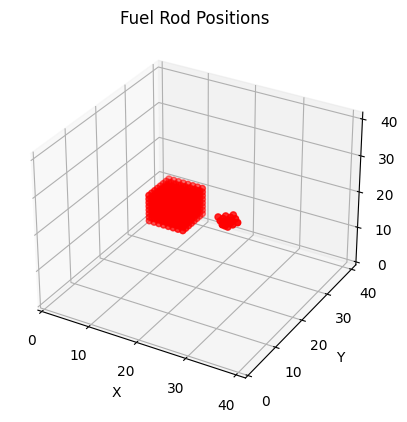

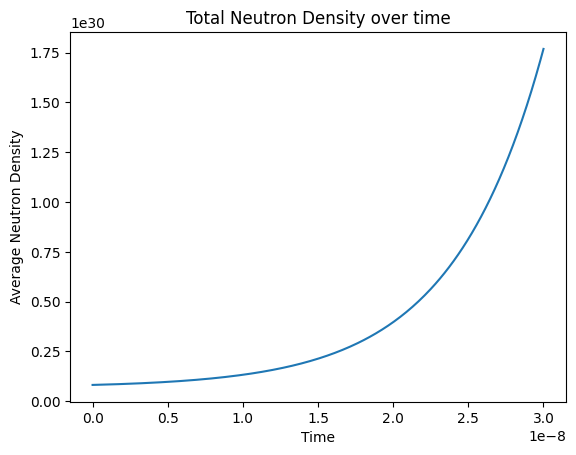

interactive(children=(IntSlider(value=0, description='Time Step', max=296), IntSlider(value=21, description='Y…

<function __main__.plot_diffusion(time_step, y_index)>

In [74]:
# Create Fuel Rod Objects
fuel_rod_1 = Shape(8, 8, 8, 'Left Hemisphere', 235, 'Uranium', 92, URANIUM_DENSITY)
fuel_rod_2 = Shape(8, 8, 8, 'Cube', 235, 'Uranium', 92, URANIUM_DENSITY)

print(f'{fuel_rod_1} \n')
print(f'{fuel_rod_2} \n')

# Set up initial conditions for both Fuel Rod Objects
initial_condition_1 = fuel_rod_1.set_initial_conditions()
initial_condition_2 = fuel_rod_2.set_initial_conditions()

# Initialize grid-spacing, timesteps, number of timesteps, total time, and density
grid_spacing: float = 1 / BOX_LENGTH
timestep_size: float = (grid_spacing ** 2 / 6 / DIFFUSION_CONST) * 0.25
t_final: float = 3e-8
num_timesteps: int = int(t_final / timestep_size)
total_density: np.ndarray = np.zeros(num_timesteps)
time: np.ndarray = np.linspace(0, t_final, num_timesteps)

# Create Grid
grid = np.zeros((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH))
object_separation = 10

# Embed fuel rods into the grid
grid = place_fuel_rods_in_grid(grid, initial_condition_1, initial_condition_2, object_separation)

# Set up boundary conditions
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
boundary_grid[-1, :, :] = True
boundary_grid[:, -1, :] = True
boundary_grid[0, :, :] = True
boundary_grid[:, 0, :] = True

# Plot the fuel rod starting positions
plot_fuel_rod_positions(grid)

# Diffuse
result = diffusion_3d(grid, grid_spacing, timestep_size, num_timesteps, boundary_grid)

# Check for nan's
if np.isnan(result).any():
    print(f'The reaction went super critical and an overflow occurred. Stopping the simulation.')
    exit()

# Calculate density
for i in range(0, num_timesteps):
    total_density[i] = np.sum(result[:, :, :, i]) / result.size

plt.figure()
plt.title(f'Total Neutron Density over time')
plt.xlabel('Time')
plt.ylabel('Average Neutron Density')
plt.plot(time, total_density)
plt.show()

# Create the slider widget for time step
time_slider = IntSlider(
    value=0,  # Initial value
    min=0,  # Minimum time step
    max=result.shape[3] - 1,  # Maximum time step
    step=1,  # Increment step
    description='Time Step'
)

y_slider = IntSlider(
    value= result.shape[1] // 2,
    min=0,
    max= result.shape[1] - 1,
    step = 1,
    description='Y-axis'
)

# Use the interact function to link the slider to the plot function
interact(plot_diffusion, time_step=time_slider, y_index=y_slider)

In [75]:
k = growth_rate(total_density)
determine_k(k[0])
determine_k(k[-1])

get_energy(total_density)

The reaction is sub-critical!
The reaction has gone super-critical!

The energy in the system initially is 2.628e+16 J
The energy in the system at the end of the simulation is 5.668e+17 J

The energy emitted/lost was 5.41e+17 J


Let's also test for a sphere colliding with a triangular prism:

Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Sphere
Length: 8m
Width: 8m
Height: 8m 

Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Triangular Prism
Length: 8m
Width: 8m
Height: 8m 



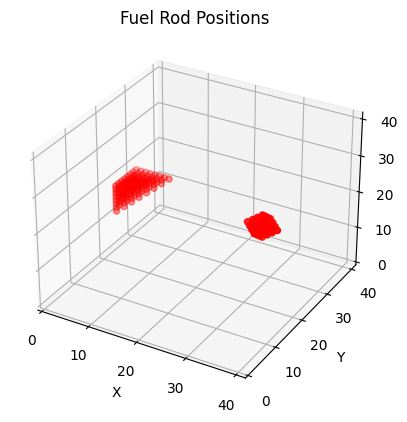

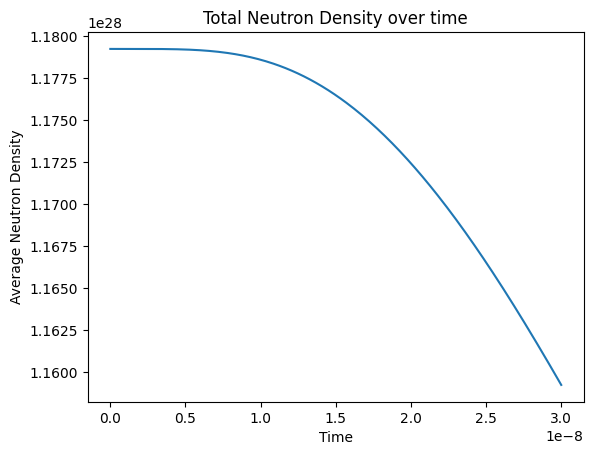

interactive(children=(IntSlider(value=0, description='Time Step', max=296), IntSlider(value=21, description='Y…

<function __main__.plot_diffusion(time_step, y_index)>

In [76]:
# Create Fuel Rod Objects
fuel_rod_1 = Shape(8, 8, 8, 'Sphere', 235, 'Uranium', 92, URANIUM_DENSITY)
fuel_rod_2 = Shape(8, 8, 8, 'Triangular Prism', 235, 'Uranium', 92, URANIUM_DENSITY)

print(f'{fuel_rod_1} \n')
print(f'{fuel_rod_2} \n')

# Set up initial conditions for both Fuel Rod Objects
initial_condition_1 = fuel_rod_1.set_initial_conditions()
initial_condition_2 = fuel_rod_2.set_initial_conditions()

# Initialize grid-spacing, timesteps, number of timesteps, total time, and density
grid_spacing: float = 1 / BOX_LENGTH
timestep_size: float = (grid_spacing ** 2 / 6 / DIFFUSION_CONST) * 0.25
t_final: float = 3e-8
num_timesteps: int = int(t_final / timestep_size)
total_density: np.ndarray = np.zeros(num_timesteps)
time: np.ndarray = np.linspace(0, t_final, num_timesteps)

# Create Grid
grid = np.zeros((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH))
object_separation = 25

# Embed fuel rods into the grid
grid = place_fuel_rods_in_grid(grid, initial_condition_1, initial_condition_2, object_separation)

# Set up boundary conditions
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
boundary_grid[-1, :, :] = True
boundary_grid[:, -1, :] = True
boundary_grid[0, :, :] = True
boundary_grid[:, 0, :] = True

# Plot the fuel rod starting positions
plot_fuel_rod_positions(grid)

# Diffuse
result = diffusion_3d(grid, grid_spacing, timestep_size, num_timesteps, boundary_grid)

# Check for nan's
if np.isnan(result).any():
    print(f'The reaction went super critical and an overflow occurred. Stopping the simulation.')
    exit()

# Calculate density
for i in range(0, num_timesteps):
    total_density[i] = np.sum(result[:, :, :, i]) / result.size

plt.figure()
plt.title(f'Total Neutron Density over time')
plt.xlabel('Time')
plt.ylabel('Average Neutron Density')
plt.plot(time, total_density)
plt.show()

# Create the slider widget for time step
time_slider = IntSlider(
    value=0,  # Initial value
    min=0,  # Minimum time step
    max=result.shape[3] - 1,  # Maximum time step
    step=1,  # Increment step
    description='Time Step'
)

y_slider = IntSlider(
    value= result.shape[1] // 2,
    min=0,
    max= result.shape[1] - 1,
    step = 1,
    description='Y-axis'
)

# Use the interact function to link the slider to the plot function
interact(plot_diffusion, time_step=time_slider, y_index=y_slider)

In [77]:
k = growth_rate(total_density)
determine_k(k[0])
determine_k(k[-1])

get_energy(total_density)

The reaction is sub-critical!
The reaction is sub-critical!

The energy in the system initially is 3.779e+15 J
The energy in the system at the end of the simulation is 3.715e+15 J

The energy emitted/lost was -6.41e+13 J


Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Sphere
Length: 8m
Width: 8m
Height: 8m 

Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Triangular Prism
Length: 8m
Width: 8m
Height: 8m 



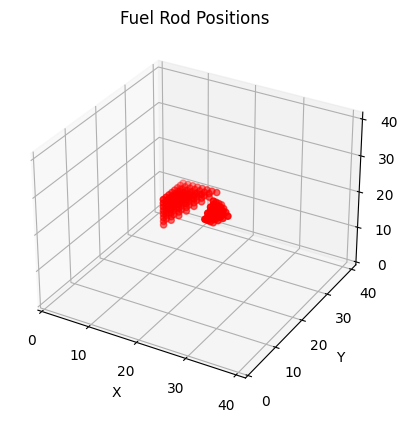

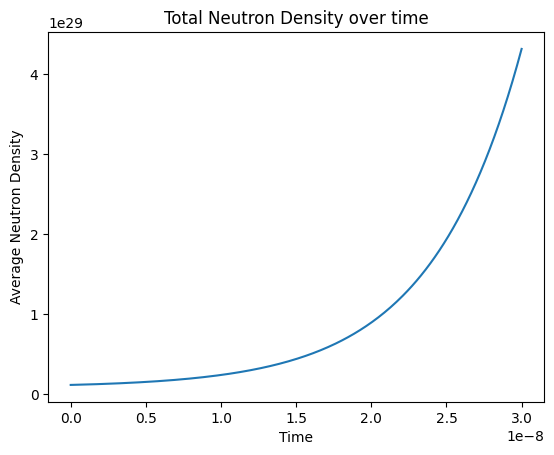

interactive(children=(IntSlider(value=0, description='Time Step', max=296), IntSlider(value=21, description='Y…

<function __main__.plot_diffusion(time_step, y_index)>

In [78]:
# Create Fuel Rod Objects
fuel_rod_1 = Shape(8, 8, 8, 'Sphere', 235, 'Uranium', 92, URANIUM_DENSITY)
fuel_rod_2 = Shape(8, 8, 8, 'Triangular Prism', 235, 'Uranium', 92, URANIUM_DENSITY)

print(f'{fuel_rod_1} \n')
print(f'{fuel_rod_2} \n')

# Set up initial conditions for both Fuel Rod Objects
initial_condition_1 = fuel_rod_1.set_initial_conditions()
initial_condition_2 = fuel_rod_2.set_initial_conditions()

# Initialize grid-spacing, timesteps, number of timesteps, total time, and density
grid_spacing: float = 1 / BOX_LENGTH
timestep_size: float = (grid_spacing ** 2 / 6 / DIFFUSION_CONST) * 0.25
t_final: float = 3e-8
num_timesteps: int = int(t_final / timestep_size)
total_density: np.ndarray = np.zeros(num_timesteps)
time: np.ndarray = np.linspace(0, t_final, num_timesteps)

# Create Grid
grid = np.zeros((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH))
object_separation = 5

# Embed fuel rods into the grid
grid = place_fuel_rods_in_grid(grid, initial_condition_1, initial_condition_2, object_separation)

# Set up boundary conditions
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
boundary_grid[-1, :, :] = True
boundary_grid[:, -1, :] = True
boundary_grid[0, :, :] = True
boundary_grid[:, 0, :] = True

# Plot the fuel rod starting positions
plot_fuel_rod_positions(grid)

# Diffuse
result = diffusion_3d(grid, grid_spacing, timestep_size, num_timesteps, boundary_grid)

# Check for nan's
if np.isnan(result).any():
    print(f'The reaction went super critical and an overflow occurred. Stopping the simulation.')
    exit()

# Calculate density
for i in range(0, num_timesteps):
    total_density[i] = np.sum(result[:, :, :, i]) / result.size

plt.figure()
plt.title(f'Total Neutron Density over time')
plt.xlabel('Time')
plt.ylabel('Average Neutron Density')
plt.plot(time, total_density)
plt.show()

# Create the slider widget for time step
time_slider = IntSlider(
    value=0,  # Initial value
    min=0,  # Minimum time step
    max=result.shape[3] - 1,  # Maximum time step
    step=1,  # Increment step
    description='Time Step'
)

y_slider = IntSlider(
    value= result.shape[1] // 2,
    min=0,
    max= result.shape[1] - 1,
    step = 1,
    description='Y-axis'
)

# Use the interact function to link the slider to the plot function
interact(plot_diffusion, time_step=time_slider, y_index=y_slider)

In [79]:
k = growth_rate(total_density)
determine_k(k[0])
determine_k(k[-1])

get_energy(total_density)

The reaction is sub-critical!
The reaction has gone super-critical!

The energy in the system initially is 3.564e+15 J
The energy in the system at the end of the simulation is 1.384e+17 J

The energy emitted/lost was 1.35e+17 J


## Plutonium-239 ##

Now that we have investigated the scenario with Uranium-235, lets simulate the reaction for a more fissile material. I will modify the simulation to use Plutonium-239. This isotope is commonly used in nuclear weapons since it contains the highest amount of fissile material. This leads to a higher reaction rate, more neutron production, and thus a higher energy output.

In [80]:
DIFFUSION_CONST = 2.6786e+5
REACTION_RATE = 3.0055E+8

Element: Plutonium-239
Z: 94
ρ: 15600.0 kg/m^3
M: 3.97e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 

Element: Plutonium-239
Z: 94
ρ: 15600.0 kg/m^3
M: 3.97e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 



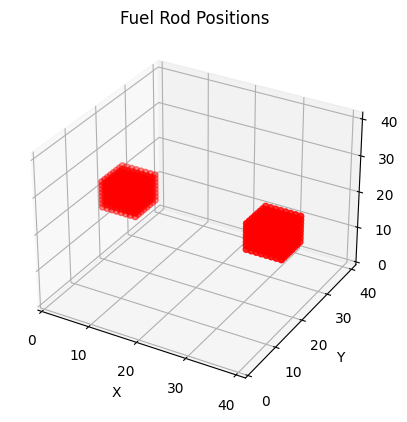

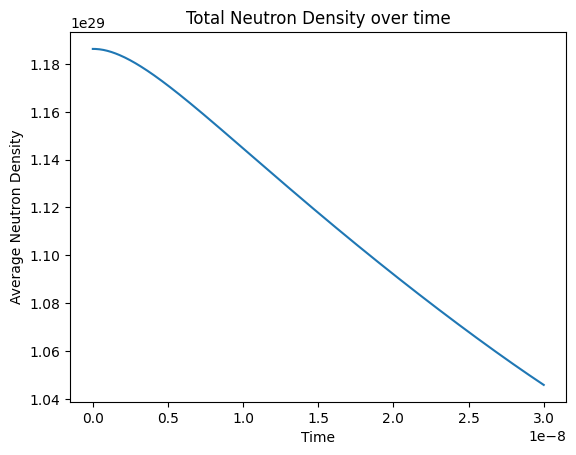

interactive(children=(IntSlider(value=0, description='Time Step', max=339), IntSlider(value=21, description='Y…

<function __main__.plot_diffusion(time_step, y_index)>

In [81]:
# Create Fuel Rod Objects
fuel_rod_1 = Shape(8, 8, 8, 'Cube', 239, 'Plutonium', 94, PLUTONIUM_DENSITY)
fuel_rod_2 = Shape(8, 8, 8, 'Cube', 239, 'Plutonium', 94, PLUTONIUM_DENSITY)

print(f'{fuel_rod_1} \n')
print(f'{fuel_rod_2} \n')

# Set up initial conditions for both Fuel Rod Objects
initial_condition_1 = fuel_rod_1.set_initial_conditions()
initial_condition_2 = fuel_rod_2.set_initial_conditions()

# Initialize grid-spacing, timesteps, number of timesteps, total time, and density
grid_spacing: float = 1 / BOX_LENGTH
timestep_size: float = (grid_spacing ** 2 / 6 / DIFFUSION_CONST) * 0.25
t_final: float = 3e-8
num_timesteps: int = int(t_final / timestep_size)
total_density: np.ndarray = np.zeros(num_timesteps)
time: np.ndarray = np.linspace(0, t_final, num_timesteps)

# Create Grid
grid = np.zeros((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH))
object_separation = 30

# Embed fuel rods into the grid
grid = place_fuel_rods_in_grid(grid, initial_condition_1, initial_condition_2, object_separation)

# Set up boundary conditions
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
boundary_grid[-1, :, :] = True
boundary_grid[:, -1, :] = True
boundary_grid[0, :, :] = True
boundary_grid[:, 0, :] = True

# Plot the fuel rod starting positions
plot_fuel_rod_positions(grid)

# Diffuse
result = diffusion_3d(grid, grid_spacing, timestep_size, num_timesteps, boundary_grid, diffusion_const=DIFFUSION_CONST, reaction_rate=REACTION_RATE)

# Check for nan's
if np.isnan(result).any():
    print(f'The reaction went super critical and an overflow occurred. Stopping the simulation.')
    exit()

# Calculate density
for i in range(0, num_timesteps):
    total_density[i] = np.sum(result[:, :, :, i]) / result.size

plt.figure()
plt.title(f'Total Neutron Density over time')
plt.xlabel('Time')
plt.ylabel('Average Neutron Density')
plt.plot(time, total_density)
plt.show()

# Create the slider widget for time step
time_slider = IntSlider(
    value=0,  # Initial value
    min=0,  # Minimum time step
    max=result.shape[3] - 1,  # Maximum time step
    step=1,  # Increment step
    description='Time Step'
)

y_slider = IntSlider(
    value= result.shape[1] // 2,
    min=0,
    max= result.shape[1] - 1,
    step = 1,
    description='Y-axis'
)

# Use the interact function to link the slider to the plot function
interact(plot_diffusion, time_step=time_slider, y_index=y_slider)

In [82]:
k = growth_rate(total_density)
determine_k(k[0])
determine_k(k[-1])

get_energy(total_density)

The reaction is sub-critical!
The reaction is sub-critical!

The energy in the system initially is 3.801e+16 J
The energy in the system at the end of the simulation is 3.351e+16 J

The energy emitted/lost was -4.50e+15 J


Element: Plutonium-239
Z: 94
ρ: 15600.0 kg/m^3
M: 3.97e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 

Element: Plutonium-239
Z: 94
ρ: 15600.0 kg/m^3
M: 3.97e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 



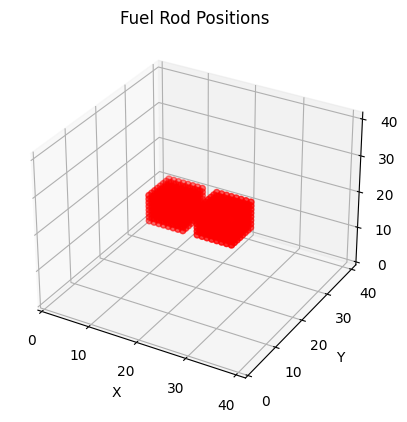

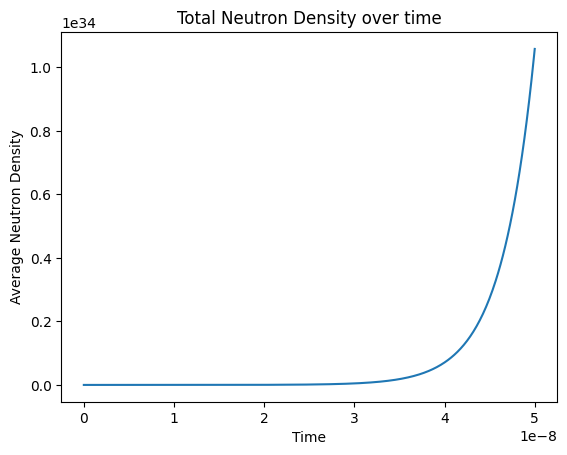

interactive(children=(IntSlider(value=0, description='Time Step', max=566), IntSlider(value=21, description='Y…

<function __main__.plot_diffusion(time_step, y_index)>

In [83]:
# Create Fuel Rod Objects
fuel_rod_1 = Shape(8, 8, 8, 'Cube', 239, 'Plutonium', 94, PLUTONIUM_DENSITY)
fuel_rod_2 = Shape(8, 8, 8, 'Cube', 239, 'Plutonium', 94, PLUTONIUM_DENSITY)

print(f'{fuel_rod_1} \n')
print(f'{fuel_rod_2} \n')

# Set up initial conditions for both Fuel Rod Objects
initial_condition_1 = fuel_rod_1.set_initial_conditions()
initial_condition_2 = fuel_rod_2.set_initial_conditions()

# Initialize grid-spacing, timesteps, number of timesteps, total time, and density
grid_spacing: float = 1 / BOX_LENGTH
timestep_size: float = (grid_spacing ** 2 / 6 / DIFFUSION_CONST) * 0.25
t_final: float = 5e-8
num_timesteps: int = int(t_final / timestep_size)
total_density: np.ndarray = np.zeros(num_timesteps)
time: np.ndarray = np.linspace(0, t_final, num_timesteps)

# Create Grid
grid = np.zeros((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH))
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
object_separation = 10

# Embed fuel rods into the grid
grid = place_fuel_rods_in_grid(grid, initial_condition_1, initial_condition_2, object_separation)

# Set up boundary conditions
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
boundary_grid[-1, :, :] = True
boundary_grid[:, -1, :] = True
boundary_grid[0, :, :] = True
boundary_grid[:, 0, :] = True

# Plot the fuel rod starting positions
plot_fuel_rod_positions(grid)

# Diffuse
result = diffusion_3d(grid, grid_spacing, timestep_size, num_timesteps, boundary_grid, diffusion_const=DIFFUSION_CONST, reaction_rate=REACTION_RATE)

# Check for nan's
if np.isnan(result).any():
    print(f'The reaction went super critical and an overflow occurred. Stopping the simulation.')
    exit()

# Calculate density
for i in range(0, num_timesteps):
    total_density[i] = np.sum(result[:, :, :, i]) / result.size

plt.figure()
plt.title(f'Total Neutron Density over time')
plt.xlabel('Time')
plt.ylabel('Average Neutron Density')
plt.plot(time, total_density)
plt.show()

# Create the slider widget for time step
time_slider = IntSlider(
    value=0,  # Initial value
    min=0,  # Minimum time step
    max=result.shape[3] - 1,  # Maximum time step
    step=1,  # Increment step
    description='Time Step'
)

y_slider = IntSlider(
    value= result.shape[1] // 2,
    min=0,
    max= result.shape[1] - 1,
    step = 1,
    description='Y-axis'
)

# Use the interact function to link the slider to the plot function
interact(plot_diffusion, time_step=time_slider, y_index=y_slider)

In [84]:
k = growth_rate(total_density)
determine_k(k[0])
determine_k(k[-1])

get_energy(total_density)

The reaction is sub-critical!
The reaction has gone super-critical!

The energy in the system initially is 2.280e+16 J
The energy in the system at the end of the simulation is 3.391e+21 J

The energy emitted/lost was 3.39e+21 J


The TSAR Bomba is the largest nuclear weapon to ever be tested in all of human history. This weapon was a Hydrogen bomb, which uses a fission reaction to produce enough energy for nuclear fusion to occur in the warhead of the bomb. This technique releases tremendous amounts more energy than that of a simple atomic bomb like we are simulating here. However, since my simulation is written in terms of SI units, the fuel rods I am using for my atomic bomb are significantly larger than that of a standard nuclear bomb. For reference, "Little Boy", the atomic bomb that was detonated over Hiroshima, Japan at the end of the second world war, used a total of 64kg of enriched Uranium 235 for its detonation device. Two 8mx8mx8m cubes of Plutonium-239 weighs approximately 20,000 tons! This is likely more Plutonium than there is in the entire Earth. Since this is just a hypothetical experiment, lets caompare it to the energy output of the TSAR Bomba:

The TSAR Bomba is estimated to have released around 210 PJ of energy. This is $210 \times 10^{15} J$ of energy! To compare to our hypothetical super bomb, which has released $4.56 \times 10^{21} J$ of energy, we can see that our simulation is roughly $21714$ times more energy!

## Neumann Boundary Conditions vs. Dirichlet Boundary Conditions ##

In this section we aim to compare how the different boundary conditions can affect the system's behaviour. In all of the previous calculations, we have utilized Dirichlet boundary conditions for our simulation. I will now copy the U $^{235}$ case for 2 colliding cubes of equal size, but impose Neumann boundary conditions instead of Dirichlet conditions. The main difference here is the Neumann boundary conditions act as a reflector on the boundary, and reflect the neutrons back into the system. Dirichlet boundarys act as absorbing boundary conditions which remove the neutrons from the system entirely. It is defined with the following mathematical relation:

$$
    \phi = \alpha
$$

Where $\alpha$ is some constant value. In our case, $\alpha = 0$, and our boundary is perfectly absorbing.

This affects the design of our nuclear device. The simulations before assumed that the neutrons that diffuse away from the fuel rods leave the system, while the Neumann conditions are set up so that our device reflects the neutrons back towards the detonation center. We can predict that the Neumann conditions should lead to a more violent explosion and release of energy since there will be more lingering neutrons in the system to interact with one another during the detonation. The Neumann boundary conditions are defined as follows:

$$
    \frac{\partial \phi}{\partial \hat{n}} = 0
$$

where $\phi$ is the neutron density, and $\hat{n}$ is the normal vector to the boundary surface.

Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 

Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 



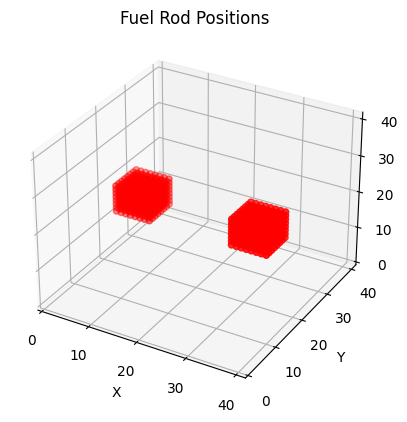

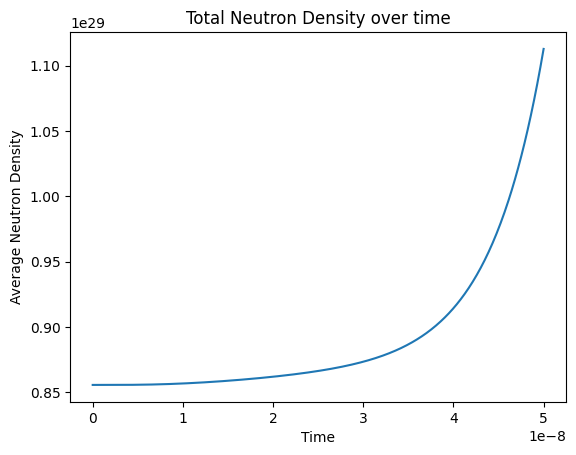

interactive(children=(IntSlider(value=0, description='Time Step', max=566), IntSlider(value=21, description='Y…

<function __main__.plot_diffusion(time_step, y_index)>

In [85]:
# Create Fuel Rod Objects
fuel_rod_1 = Shape(8, 8, 8, 'Cube', 235, 'Uranium', 92, URANIUM_DENSITY)
fuel_rod_2 = Shape(8, 8, 8, 'Cube', 235, 'Uranium', 92, URANIUM_DENSITY)

print(f'{fuel_rod_1} \n')
print(f'{fuel_rod_2} \n')

# Set up initial conditions for both Fuel Rod Objects
initial_condition_1 = fuel_rod_1.set_initial_conditions()
initial_condition_2 = fuel_rod_2.set_initial_conditions()

# Initialize grid-spacing, timesteps, number of timesteps, total time, and density
grid_spacing: float       = 1 / BOX_LENGTH
timestep_size: float      = (grid_spacing ** 2 / 6 / DIFFUSION_CONST) * 0.25
t_final: float            = 5e-8
num_timesteps: int        = int(t_final / timestep_size)
total_density: np.ndarray = np.zeros(num_timesteps)
time: np.ndarray          = np.linspace(0, t_final, num_timesteps)

# Create Grid
grid = np.zeros((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH))
object_separation = 25

# Embed fuel rods into the grid
grid = place_fuel_rods_in_grid(grid, initial_condition_1, initial_condition_2, object_separation)

# Set up boundary conditions
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
boundary_grid[-1, :, :] = True
boundary_grid[:, -1, :] = True
boundary_grid[0, :, :] = True
boundary_grid[:, 0, :] = True


# Plot the fuel rod starting positions
plot_fuel_rod_positions(grid)

# Diffuse
result = diffusion_3d(grid, grid_spacing, timestep_size, num_timesteps, boundary_grid, boundary_type="neumann")

# Check for nan's
if np.isnan(result).any():
    print(f'The reaction went super critical and an overflow occurred. Stopping the simulation.')
    exit()
    
# Calculate density
for i in range(0, num_timesteps):
    total_density[i] = np.sum(result[:, :, :, i]) / result.size

plt.figure()
plt.title(f'Total Neutron Density over time')
plt.xlabel('Time')
plt.ylabel('Average Neutron Density')
plt.plot(time[:], total_density[:])
plt.show()

# Create the slider widget for time step
time_slider = IntSlider(
    value=0,  # Initial value
    min=0,  # Minimum time step
    max=result.shape[3] - 1,  # Maximum time step
    step=1,  # Increment step
    description='Time Step'
)

y_slider = IntSlider(
    value= result.shape[1] // 2,
    min=0,
    max= result.shape[1] - 1,
    step = 1,
    description='Y-axis'
)

# Use the interact function to link the slider to the plot function
interact(plot_diffusion, time_step=time_slider, y_index=y_slider)

In [86]:
k = growth_rate(total_density)
determine_k(k[0])
determine_k(k[-1])

get_energy(total_density)

The reaction is sub-critical!
The reaction has gone super-critical!

The energy in the system initially is 2.742e+16 J
The energy in the system at the end of the simulation is 3.566e+16 J

The energy emitted/lost was 8.24e+15 J


Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 

Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 



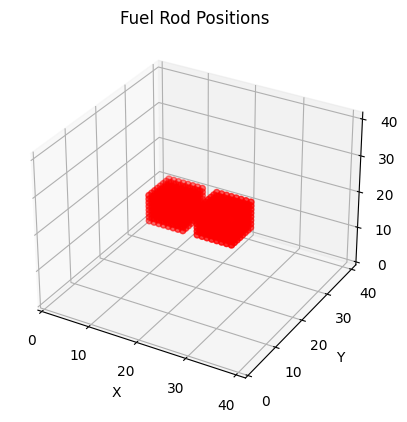

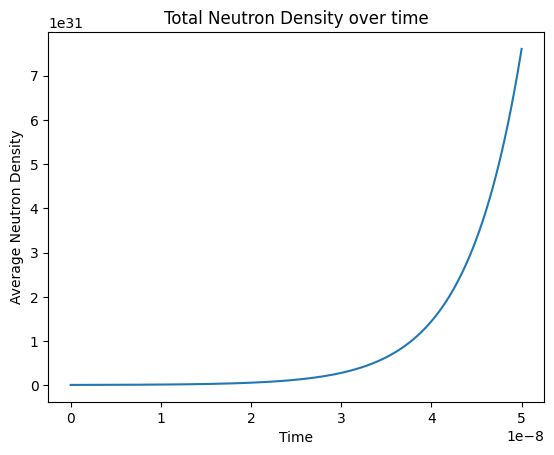

interactive(children=(IntSlider(value=0, description='Time Step', max=566), IntSlider(value=21, description='Y…

<function __main__.plot_diffusion(time_step, y_index)>

In [87]:
# Create Fuel Rod Objects
fuel_rod_1 = Shape(8, 8, 8, 'Cube', 235, 'Uranium', 92, URANIUM_DENSITY)
fuel_rod_2 = Shape(8, 8, 8, 'Cube', 235, 'Uranium', 92, URANIUM_DENSITY)

print(f'{fuel_rod_1} \n')
print(f'{fuel_rod_2} \n')

# Set up initial conditions for both Fuel Rod Objects
initial_condition_1 = fuel_rod_1.set_initial_conditions()
initial_condition_2 = fuel_rod_2.set_initial_conditions()

# Initialize grid-spacing, timesteps, number of timesteps, total time, and density
grid_spacing: float       = 1 / BOX_LENGTH
timestep_size: float      = (grid_spacing ** 2 / 6 / DIFFUSION_CONST) * 0.25
t_final: float            = 5e-8
num_timesteps: int        = int(t_final / timestep_size)
total_density: np.ndarray = np.zeros(num_timesteps)
time: np.ndarray          = np.linspace(0, t_final, num_timesteps)

# Create Grid
grid = np.zeros((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH))
object_separation = 10

# Embed fuel rods into the grid
grid = place_fuel_rods_in_grid(grid, initial_condition_1, initial_condition_2, object_separation)

# Set up boundary conditions
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
boundary_grid[-1, :, :] = True
boundary_grid[:, -1, :] = True
boundary_grid[0, :, :] = True
boundary_grid[:, 0, :] = True


# Plot the fuel rod starting positions
plot_fuel_rod_positions(grid)

# Diffuse
result = diffusion_3d(grid, grid_spacing, timestep_size, num_timesteps, boundary_grid)

# Check for nan's
if np.isnan(result).any():
    print(f'The reaction went super critical and an overflow occurred. Stopping the simulation.')
    exit()
    
# Calculate density
for i in range(0, num_timesteps):
    total_density[i] = np.sum(result[:, :, :, i]) / result.size

plt.figure()
plt.title(f'Total Neutron Density over time')
plt.xlabel('Time')
plt.ylabel('Average Neutron Density')
plt.plot(time[:], total_density[:])
plt.show()

# Create the slider widget for time step
time_slider = IntSlider(
    value=0,  # Initial value
    min=0,  # Minimum time step
    max=result.shape[3] - 1,  # Maximum time step
    step=1,  # Increment step
    description='Time Step'
)

y_slider = IntSlider(
    value= result.shape[1] // 2,
    min=0,
    max= result.shape[1] - 1,
    step = 1,
    description='Y-axis'
)

# Use the interact function to link the slider to the plot function
interact(plot_diffusion, time_step=time_slider, y_index=y_slider)

So we can already see here that unlike the Dirichlet boundary conditions, the neumann boundary conditions have significantly less dissipation of neutrons, and the overall density at the final timestep is much greater. Lets look and see what happens if we bring the cubes closer together:

Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 

Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 



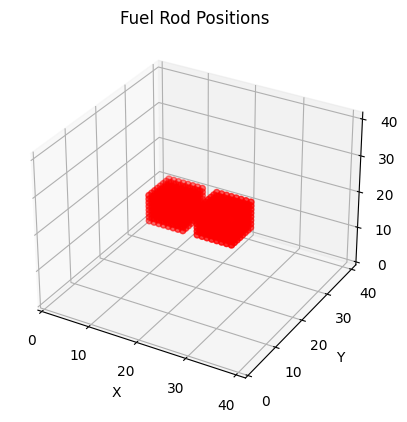

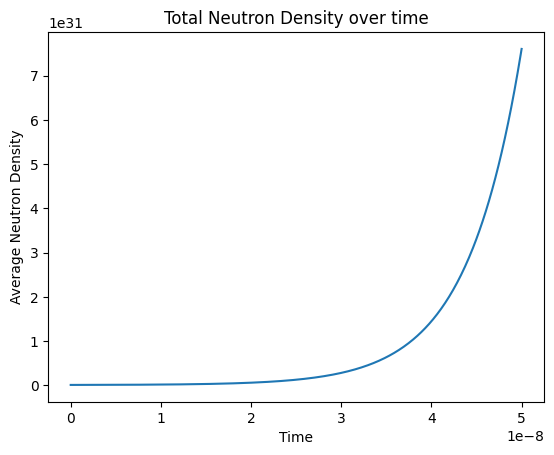

interactive(children=(IntSlider(value=0, description='Time Step', max=566), IntSlider(value=21, description='Y…

<function __main__.plot_diffusion(time_step, y_index)>

In [88]:
# Create Fuel Rod Objects
fuel_rod_1 = Shape(8, 8, 8, 'Cube', 235, 'Uranium', 92, URANIUM_DENSITY)
fuel_rod_2 = Shape(8, 8, 8, 'Cube', 235, 'Uranium', 92, URANIUM_DENSITY)

print(f'{fuel_rod_1} \n')
print(f'{fuel_rod_2} \n')

# Set up initial conditions for both Fuel Rod Objects
initial_condition_1 = fuel_rod_1.set_initial_conditions()
initial_condition_2 = fuel_rod_2.set_initial_conditions()

# Initialize grid-spacing, timesteps, number of timesteps, total time, and density
grid_spacing: float       = 1 / BOX_LENGTH
timestep_size: float      = (grid_spacing ** 2 / 6 / DIFFUSION_CONST) * 0.25
t_final: float            = 5e-8
num_timesteps: int        = int(t_final / timestep_size)
total_density: np.ndarray = np.zeros(num_timesteps)
time: np.ndarray          = np.linspace(0, t_final, num_timesteps)

# Create Grid
grid = np.zeros((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH))
object_separation = 10

# Embed fuel rods into the grid
grid = place_fuel_rods_in_grid(grid, initial_condition_1, initial_condition_2, object_separation)

# Set up boundary conditions
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
boundary_grid[-1, :, :] = True
boundary_grid[:, -1, :] = True
boundary_grid[0, :, :] = True
boundary_grid[:, 0, :] = True


# Plot the fuel rod starting positions
plot_fuel_rod_positions(grid)

# Diffuse
result = diffusion_3d(grid, grid_spacing, timestep_size, num_timesteps, boundary_grid, boundary_type="neumann")

# Check for nan's
if np.isnan(result).any():
    print(f'The reaction went super critical and an overflow occurred. Stopping the simulation.')
    exit()
    
# Calculate density
for i in range(0, num_timesteps):
    total_density[i] = np.sum(result[:, :, :, i]) / result.size

plt.figure()
plt.title(f'Total Neutron Density over time')
plt.xlabel('Time')
plt.ylabel('Average Neutron Density')
plt.plot(time, total_density)
plt.show()

# Create the slider widget for time step
time_slider = IntSlider(
    value=0,  # Initial value
    min=0,  # Minimum time step
    max=result.shape[3] - 1,  # Maximum time step
    step=1,  # Increment step
    description='Time Step'
)

y_slider = IntSlider(
    value= result.shape[1] // 2,
    min=0,
    max= result.shape[1] - 1,
    step = 1,
    description='Y-axis'
)

# Use the interact function to link the slider to the plot function
interact(plot_diffusion, time_step=time_slider, y_index=y_slider)

In [89]:
k = growth_rate(total_density)
determine_k(k[0])
determine_k(k[-1])

get_energy(total_density)

The reaction is sub-critical!
The reaction has gone super-critical!

The energy in the system initially is 2.742e+16 J
The energy in the system at the end of the simulation is 2.437e+19 J

The energy emitted/lost was 2.43e+19 J


We still get a similar explosion in the center, but the values around the edges of the simulation are much greater! We can conclude here that the effect only really makes a difference in neutron density when the objects are closer to the boundaries and farther away. This is likely because the reaction is strong enough at the center that the production of neutrons overpowers the absorbing or reflecting boundary conditions. 

The most important thing to notice however is that the Neumann boundary conditions require the objects to be farther apart. Since the average density in the simulation grid is higher even at farther separation distances, the chance of an explosion is very high. We can conclude that Dirichlet boundary conditions should be used when trying to keep a stable reaction (at $k = 1$ for example) where the fuel rods are either slowly decaying, or equally producing neutrons and losing them. Neumann boundary conditions should be used in the design of something like a nuclear weapon, since more neutrons are staying in the simulation.

## When do we go critical? ##

So far, I have shown that as the fuel rods get closer together, they eventually reach a point where the regions of interfereing flux make the production of neutrons an exponential growth instead of decay. In this section I will investigate where exactly this happens, for both he Uranium-235 case with Dirichlet boundaries, and the Plutonium Case with Dirichlet boundaries. Dirichlet boundaries are being considered here instead of Neumann boundaries since we only really care about the neutrons interacting in the center of the grid, and keeping the neutrons on the boundaries just increases the density of neutrons everywhere making it harder to analyze the criticality condition.

Starting in a region between a separation distance of 20 and 30, we can move the blocks slightly farther and farther away from one another until we no longer go critical. This will give us a close approximation of how far apart they need to be.

### U $^{235}$ Case ###

Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 

Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 



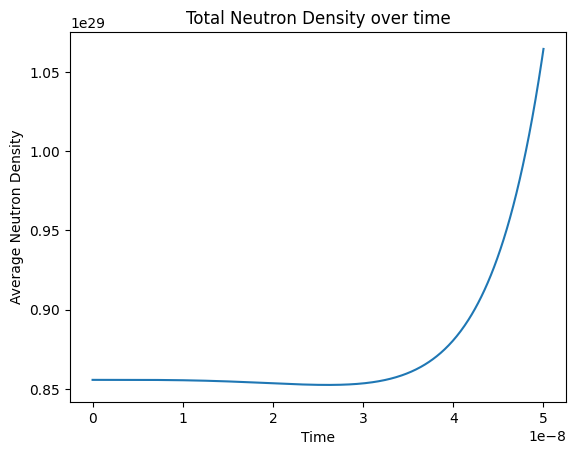

In [90]:
# Create Fuel Rod Objects
fuel_rod_1 = Shape(8, 8, 8, 'Cube', 235, 'Uranium', 92, URANIUM_DENSITY)
fuel_rod_2 = Shape(8, 8, 8, 'Cube', 235, 'Uranium', 92, URANIUM_DENSITY)

print(f'{fuel_rod_1} \n')
print(f'{fuel_rod_2} \n')

# Set up initial conditions for both Fuel Rod Objects
initial_condition_1 = fuel_rod_1.set_initial_conditions()
initial_condition_2 = fuel_rod_2.set_initial_conditions()

# Initialize grid-spacing, timesteps, number of timesteps, total time, and density
grid_spacing: float       = 1 / BOX_LENGTH
timestep_size: float      = (grid_spacing ** 2 / 6 / DIFFUSION_CONST) * 0.25
t_final: float            = 5e-8
num_timesteps: int        = int(t_final / timestep_size)
total_density: np.ndarray = np.zeros(num_timesteps)
time: np.ndarray          = np.linspace(0, t_final, num_timesteps)

# Create Grid
grid = np.zeros((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH))
object_separation = 25

# Embed fuel rods into the grid
grid = place_fuel_rods_in_grid(grid, initial_condition_1, initial_condition_2, object_separation)

# Set up boundary conditions
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
boundary_grid[-1, :, :] = True
boundary_grid[:, -1, :] = True
boundary_grid[0, :, :] = True
boundary_grid[:, 0, :] = True

# Diffuse
result = diffusion_3d(grid, grid_spacing, timestep_size, num_timesteps, boundary_grid)

# Check for nan's
if np.isnan(result).any():
    print(f'The reaction went super critical and an overflow occurred. Stopping the simulation.')
    exit()
    
# Calculate density
for i in range(0, num_timesteps):
    total_density[i] = np.sum(result[:, :, :, i]) / result.size

plt.figure()
plt.title(f'Total Neutron Density over time')
plt.xlabel('Time')
plt.ylabel('Average Neutron Density')
plt.plot(time, total_density)
plt.show()

Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 

Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 



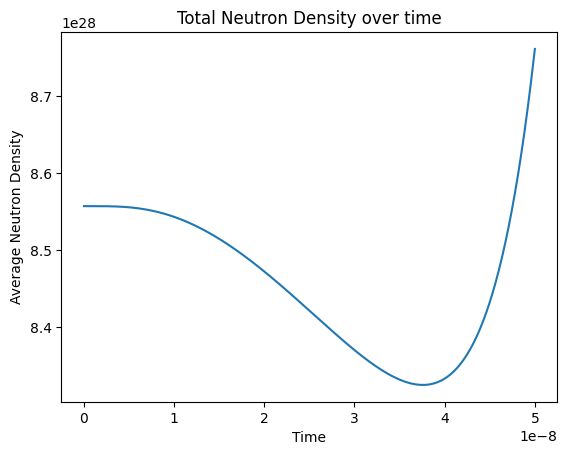

In [91]:
# Create Fuel Rod Objects
fuel_rod_1 = Shape(8, 8, 8, 'Cube', 235, 'Uranium', 92, URANIUM_DENSITY)
fuel_rod_2 = Shape(8, 8, 8, 'Cube', 235, 'Uranium', 92, URANIUM_DENSITY)

print(f'{fuel_rod_1} \n')
print(f'{fuel_rod_2} \n')

# Set up initial conditions for both Fuel Rod Objects
initial_condition_1 = fuel_rod_1.set_initial_conditions()
initial_condition_2 = fuel_rod_2.set_initial_conditions()

# Initialize grid-spacing, timesteps, number of timesteps, total time, and density
grid_spacing: float       = 1 / BOX_LENGTH
timestep_size: float      = (grid_spacing ** 2 / 6 / DIFFUSION_CONST) * 0.25
t_final: float            = 5e-8
num_timesteps: int        = int(t_final / timestep_size)
total_density: np.ndarray = np.zeros(num_timesteps)
time: np.ndarray          = np.linspace(0, t_final, num_timesteps)

# Create Grid
grid = np.zeros((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH))
object_separation = 27

# Embed fuel rods into the grid
grid = place_fuel_rods_in_grid(grid, initial_condition_1, initial_condition_2, object_separation)

# Set up boundary conditions
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
boundary_grid[-1, :, :] = True
boundary_grid[:, -1, :] = True
boundary_grid[0, :, :] = True
boundary_grid[:, 0, :] = True

# Diffuse
result = diffusion_3d(grid, grid_spacing, timestep_size, num_timesteps, boundary_grid)

# Check for nan's
if np.isnan(result).any():
    print(f'The reaction went super critical and an overflow occurred. Stopping the simulation.')
    exit()
    
# Calculate density
for i in range(0, num_timesteps):
    total_density[i] = np.sum(result[:, :, :, i]) / result.size

plt.figure()
plt.title(f'Total Neutron Density over time')
plt.xlabel('Time')
plt.ylabel('Average Neutron Density')
plt.plot(time, total_density)
plt.show()

We are getting close here, almost all of the diffused neutrons have dissapeared or spread themselved out before the interacting flux's meet in the center. 

Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 

Element: Uranium-235
Z: 92
ρ: 18710.0 kg/m^3
M: 3.90e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 



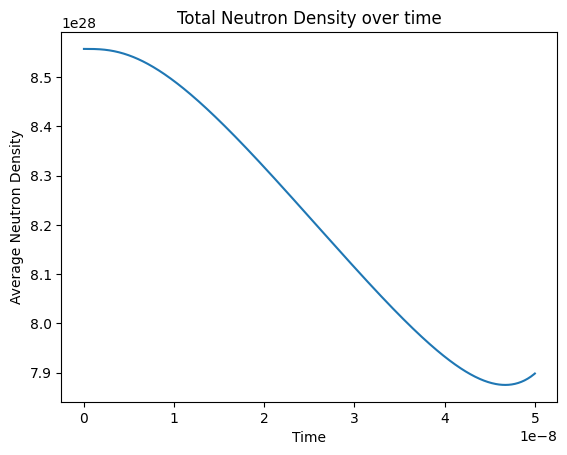

In [92]:
# Create Fuel Rod Objects
fuel_rod_1 = Shape(8, 8, 8, 'Cube', 235, 'Uranium', 92, URANIUM_DENSITY)
fuel_rod_2 = Shape(8, 8, 8, 'Cube', 235, 'Uranium', 92, URANIUM_DENSITY)

print(f'{fuel_rod_1} \n')
print(f'{fuel_rod_2} \n')

# Set up initial conditions for both Fuel Rod Objects
initial_condition_1 = fuel_rod_1.set_initial_conditions()
initial_condition_2 = fuel_rod_2.set_initial_conditions()

# Initialize grid-spacing, timesteps, number of timesteps, total time, and density
grid_spacing: float       = 1 / BOX_LENGTH
timestep_size: float      = (grid_spacing ** 2 / 6 / DIFFUSION_CONST) * 0.25
t_final: float            = 5e-8
num_timesteps: int        = int(t_final / timestep_size)
total_density: np.ndarray = np.zeros(num_timesteps)
time: np.ndarray          = np.linspace(0, t_final, num_timesteps)

# Create Grid
grid = np.zeros((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH))
object_separation = 28

# Embed fuel rods into the grid
grid = place_fuel_rods_in_grid(grid, initial_condition_1, initial_condition_2, object_separation)

# Set up boundary conditions
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
boundary_grid[-1, :, :] = True
boundary_grid[:, -1, :] = True
boundary_grid[0, :, :] = True
boundary_grid[:, 0, :] = True

# Diffuse
result = diffusion_3d(grid, grid_spacing, timestep_size, num_timesteps, boundary_grid)

# Check for nan's
if np.isnan(result).any():
    print(f'The reaction went super critical and an overflow occurred. Stopping the simulation.')
    exit()
    
# Calculate density
for i in range(0, num_timesteps):
    total_density[i] = np.sum(result[:, :, :, i]) / result.size

plt.figure()
plt.title(f'Total Neutron Density over time')
plt.xlabel('Time')
plt.ylabel('Average Neutron Density')
plt.plot(time, total_density)
plt.show()

As expected, as a separation distance of 28m the reaction no longer occurs. So for 2 VERY LARGE uranium blocks, they should be kept around 28m apart. Note that the distance scale is quite large here but that is just because the objects are also massive. Reducing the objects to a few centimeters would greatly reduce the separation distance. Since the greatest surface area is always a square, the cubes will have the highest flux interacting with one another, and thus have the highest energy output. The other objects have a smaller surface area to diffuse from, and thus can be kept slightly closer together. It is probably wise to keep these theoretical objects as far apart as possible though, unless you are trying to create an explosion bigger than any ever seen on Earth.

### Pu $^{239}$ ###

Starting with a separation of 36m and working our way closer this time:

In [99]:
BOX_LENGTH = 45

Element: Plutonium-239
Z: 94
ρ: 15600.0 kg/m^3
M: 3.97e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 

Element: Plutonium-239
Z: 94
ρ: 15600.0 kg/m^3
M: 3.97e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 



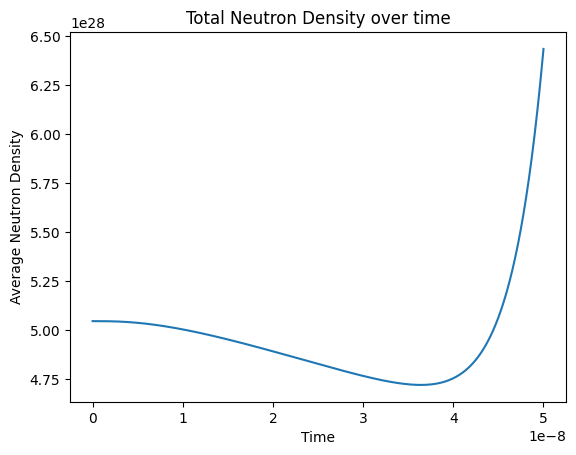

In [101]:
# Create Fuel Rod Objects
fuel_rod_1 = Shape(8, 8, 8, 'Cube', 239, 'Plutonium', 94, PLUTONIUM_DENSITY)
fuel_rod_2 = Shape(8, 8, 8, 'Cube', 239, 'Plutonium', 94, PLUTONIUM_DENSITY)

print(f'{fuel_rod_1} \n')
print(f'{fuel_rod_2} \n')

# Set up initial conditions for both Fuel Rod Objects
initial_condition_1 = fuel_rod_1.set_initial_conditions()
initial_condition_2 = fuel_rod_2.set_initial_conditions()

# Initialize grid-spacing, timesteps, number of timesteps, total time, and density
grid_spacing: float = 1 / BOX_LENGTH
timestep_size: float = (grid_spacing ** 2 / 6 / DIFFUSION_CONST) * 0.25
t_final: float = 5e-8
num_timesteps: int = int(t_final / timestep_size)
total_density: np.ndarray = np.zeros(num_timesteps)
time: np.ndarray = np.linspace(0, t_final, num_timesteps)

# Create Grid
grid = np.zeros((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH))
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
object_separation = 31

# Embed fuel rods into the grid
grid = place_fuel_rods_in_grid(grid, initial_condition_1, initial_condition_2, object_separation)

# Set up boundary conditions
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
boundary_grid[-1, :, :] = True
boundary_grid[:, -1, :] = True
boundary_grid[0, :, :] = True
boundary_grid[:, 0, :] = True

# Diffuse
result = diffusion_3d(grid, grid_spacing, timestep_size, num_timesteps, boundary_grid, diffusion_const=DIFFUSION_CONST, reaction_rate=REACTION_RATE)

# Check for nan's
if np.isnan(result).any():
    print(f'The reaction went super critical and an overflow occurred. Stopping the simulation.')
    exit()

# Calculate density
for i in range(0, num_timesteps):
    total_density[i] = np.sum(result[:, :, :, i]) / result.size

plt.figure()
plt.title(f'Total Neutron Density over time')
plt.xlabel('Time')
plt.ylabel('Average Neutron Density')
plt.plot(time, total_density)
plt.show()

Element: Plutonium-239
Z: 94
ρ: 15600.0 kg/m^3
M: 3.97e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 

Element: Plutonium-239
Z: 94
ρ: 15600.0 kg/m^3
M: 3.97e-25 kg
Shape: Cube
Length: 8m
Width: 8m
Height: 8m 



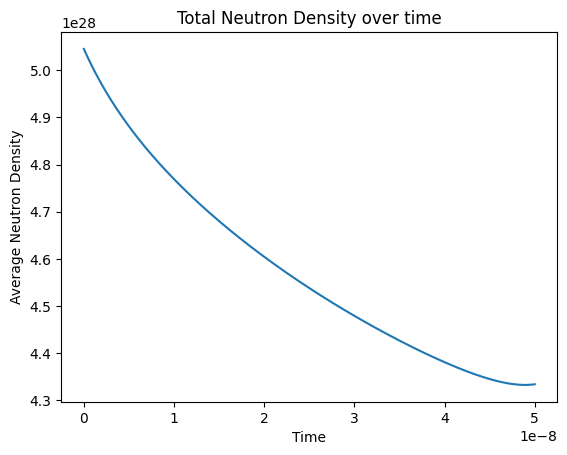

In [103]:
# Create Fuel Rod Objects
fuel_rod_1 = Shape(8, 8, 8, 'Cube', 239, 'Plutonium', 94, PLUTONIUM_DENSITY)
fuel_rod_2 = Shape(8, 8, 8, 'Cube', 239, 'Plutonium', 94, PLUTONIUM_DENSITY)

print(f'{fuel_rod_1} \n')
print(f'{fuel_rod_2} \n')

# Set up initial conditions for both Fuel Rod Objects
initial_condition_1 = fuel_rod_1.set_initial_conditions()
initial_condition_2 = fuel_rod_2.set_initial_conditions()

# Initialize grid-spacing, timesteps, number of timesteps, total time, and density
grid_spacing: float = 1 / BOX_LENGTH
timestep_size: float = (grid_spacing ** 2 / 6 / DIFFUSION_CONST) * 0.25
t_final: float = 5e-8
num_timesteps: int = int(t_final / timestep_size)
total_density: np.ndarray = np.zeros(num_timesteps)
time: np.ndarray = np.linspace(0, t_final, num_timesteps)

# Create Grid
grid = np.zeros((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH))
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
object_separation = 36

# Embed fuel rods into the grid
grid = place_fuel_rods_in_grid(grid, initial_condition_1, initial_condition_2, object_separation)

# Set up boundary conditions
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
boundary_grid[-1, :, :] = True
boundary_grid[:, -1, :] = True
boundary_grid[0, :, :] = True
boundary_grid[:, 0, :] = True

# Diffuse
result = diffusion_3d(grid, grid_spacing, timestep_size, num_timesteps, boundary_grid, diffusion_const=DIFFUSION_CONST, reaction_rate=REACTION_RATE)

# Check for nan's
if np.isnan(result).any():
    print(f'The reaction went super critical and an overflow occurred. Stopping the simulation.')
    exit()

# Calculate density
for i in range(0, num_timesteps):
    total_density[i] = np.sum(result[:, :, :, i]) / result.size

plt.figure()
plt.title(f'Total Neutron Density over time')
plt.xlabel('Time')
plt.ylabel('Average Neutron Density')
plt.plot(time, total_density)
plt.show()

We can see here that at a separation distance of 25m, the Plutonium rod's reaction becomes super-critical. Note here that the simulation time for Plutonium is actually smaller than that of the Uranium case. This is because the diffusion constant and reaction rate are higher, thus leading to a faster diffusion and fission of neutrons. The blocks should probably be kept more than 30m apart, since as time progresses in the Plutonium case, the neutrons can multiply very quickly.

## Which materials are best? ##

After looking at the many graphs produced we can see that the plutonium case always has a higher energy output within the system given the same simulation time. Particularly in the case of the two cubes at 10m apart, we can compare the result of $4.56\cdot 10^{21} J$ to that of the Uranium bomb with the same separation and time evolution which **only** yielded $3.66 \cdot 10^{19} J$. 

For our simulation, Plutonium-239 is clearly the better choice, since its reaction rate and diffusion constant are much larger than Uranium. It is however less practical since enriched Plutonium-239 is much harder to obtain than Uranium-235. In either case, these blocks of material are massive and are definitely overkill. 

Choosing the best material for the fission process corresponds to choosing the material with the highest diffusion constant and reaction rate possible.

## Minimum Material Size ##

How small can we make the objects such that they don't diffuse at all anymore? To do this, we will have to modify our initial conditions. Right now the shape class is set up with densities and sizing in meters. modifying it to support a smaller value is very simple, we just have to treat the fuel rod as a point with specified density. This is akin to making a very very small fuel rod. Since the normal density of neutrons per cubic meter in Uranium is $310,500$, making a cube shaped fuel rod that is 1mm in length is akin to multiplying that source in the grid by $10^{-9}m / mm$. So we have a new density of $3.105$ neutrons/m. We can keep the class the same, but multiply our density by a conversion factor at the end to adjust the density and thus, emulate a smaller material being placed in the grid. This method preserves our dimensionality in SI units as well.

Lets find the minimum size for both Uranium-235 and Plutonium-239 for an object 10m apart:

In [ ]:
BOX_LENGTH = 40

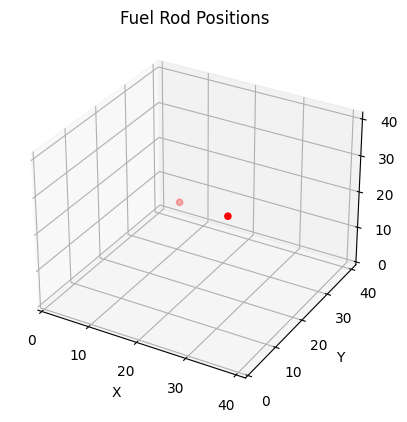

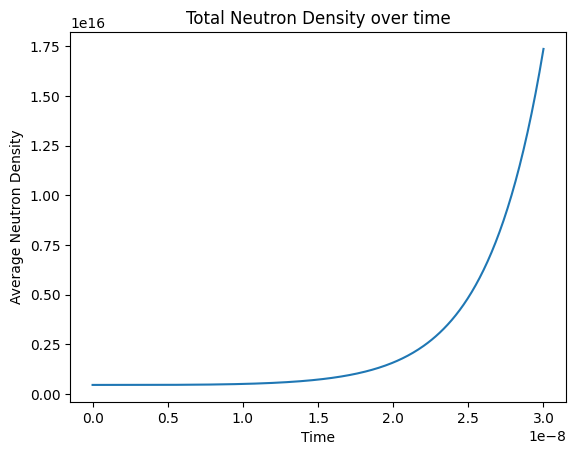

interactive(children=(IntSlider(value=0, description='Time Step', max=339), IntSlider(value=21, description='Y…

<function __main__.plot_diffusion(time_step, y_index)>

In [95]:
# Create Fuel Rod Objects
fuel_rod_1 = Shape(1, 1, 1, 'Cube', 239, 'Plutonium', 94, PLUTONIUM_DENSITY)
fuel_rod_2 = Shape(1, 1, 1, 'Cube', 239, 'Plutonium', 94, PLUTONIUM_DENSITY)

# Set up initial conditions for both Fuel Rod Objects
#============ ADJUSTED SIZE ==================================#
initial_condition_1 = fuel_rod_1.set_initial_conditions() * 1e-9
initial_condition_2 = fuel_rod_2.set_initial_conditions() * 1e-9

# Initialize grid-spacing, timesteps, number of timesteps, total time, and density
grid_spacing: float = 1 / BOX_LENGTH
timestep_size: float = (grid_spacing ** 2 / 6 / DIFFUSION_CONST) * 0.25
t_final: float = 3e-8
num_timesteps: int = int(t_final / timestep_size)
total_density: np.ndarray = np.zeros(num_timesteps)
time: np.ndarray = np.linspace(0, t_final, num_timesteps)

# Create Grid
grid = np.zeros((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH))
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
object_separation = 10

# Embed fuel rods into the grid
grid = place_fuel_rods_in_grid(grid, initial_condition_1, initial_condition_2, object_separation)

# Set up boundary conditions
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
boundary_grid[-1, :, :] = True
boundary_grid[:, -1, :] = True
boundary_grid[0, :, :] = True
boundary_grid[:, 0, :] = True

# Plot the fuel rod starting positions
plot_fuel_rod_positions(grid)

# Diffuse
result = diffusion_3d(grid, grid_spacing, timestep_size, num_timesteps, boundary_grid, diffusion_const=DIFFUSION_CONST, reaction_rate=REACTION_RATE)

# Check for nan's
if np.isnan(result).any():
    print(f'The reaction went super critical and an overflow occurred. Stopping the simulation.')
    exit()

# Calculate density
for i in range(0, num_timesteps):
    total_density[i] = np.sum(result[:, :, :, i]) / result.size

plt.figure()
plt.title(f'Total Neutron Density over time')
plt.xlabel('Time')
plt.ylabel('Average Neutron Density')
plt.plot(time, total_density)
plt.show()


# Create the slider widget for time step
time_slider = IntSlider(
    value=0,  # Initial value
    min=0,  # Minimum time step
    max=result.shape[3] - 1,  # Maximum time step
    step=1,  # Increment step
    description='Time Step'
)

y_slider = IntSlider(
    value= result.shape[1] // 2,
    min=0,
    max= result.shape[1] - 1,
    step = 1,
    description='Y-axis'
)

# Use the interact function to link the slider to the plot function
interact(plot_diffusion, time_step=time_slider, y_index=y_slider)

In [96]:
k = growth_rate(total_density)
determine_k(k[0])
determine_k(k[-1])

get_energy(total_density)

The reaction is sub-critical!
The reaction has gone super-critical!

The energy in the system initially is 1.450e+02 J
The energy in the system at the end of the simulation is 5.566e+03 J

The energy emitted/lost was 5.42e+03 J


In this case, the reaction of 2 1mm cubes only produces 5880 J. The specific heat capacity of water is defined by:

$$
    c = 4184 J/kg ^\circ C
$$

Which can be used in the following heat equation from Chemistry:
$$
    Q = mc \Delta T
$$

So we can say that this reaction is enough to heat up a $250mL$ cup of water by $5.64^\circ C$.

This is not a lot of energy, and is roughly in a stable state, so I will consider this reaction non-super-critical, since the output of energy really isnt high enough to be meaningful and likely would be absorbed or lost during the process of starting the diffusion anyways. Lets try something as large as a 1cm cube and see what happens:

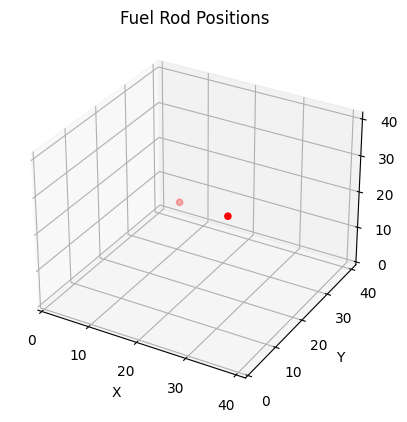

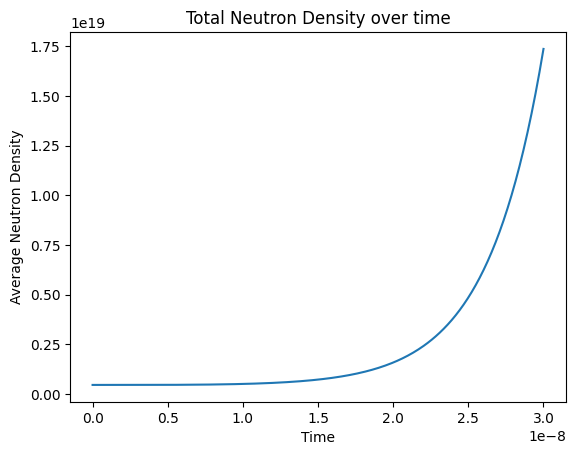

interactive(children=(IntSlider(value=0, description='Time Step', max=339), IntSlider(value=21, description='Y…

The reaction is sub-critical!
The reaction has gone super-critical!

The energy in the system initially is 1.450e+05 J
The energy in the system at the end of the simulation is 5.566e+06 J

The energy emitted/lost was 5.42e+06 J


In [97]:
# Create Fuel Rod Objects
fuel_rod_1 = Shape(1, 1, 1, 'Cube', 239, 'Plutonium', 94, PLUTONIUM_DENSITY)
fuel_rod_2 = Shape(1, 1, 1, 'Cube', 239, 'Plutonium', 94, PLUTONIUM_DENSITY)

# Set up initial conditions for both Fuel Rod Objects
#============ ADJUSTED SIZE ==================================#
initial_condition_1 = fuel_rod_1.set_initial_conditions() * 1e-6
initial_condition_2 = fuel_rod_2.set_initial_conditions() * 1e-6

# Initialize grid-spacing, timesteps, number of timesteps, total time, and density
grid_spacing: float = 1 / BOX_LENGTH
timestep_size: float = (grid_spacing ** 2 / 6 / DIFFUSION_CONST) * 0.25
t_final: float = 3e-8
num_timesteps: int = int(t_final / timestep_size)
total_density: np.ndarray = np.zeros(num_timesteps)
time: np.ndarray = np.linspace(0, t_final, num_timesteps)

# Create Grid
grid = np.zeros((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH))
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
object_separation = 10

# Embed fuel rods into the grid
grid = place_fuel_rods_in_grid(grid, initial_condition_1, initial_condition_2, object_separation)

# Set up boundary conditions
boundary_grid = np.full((BOX_LENGTH, BOX_LENGTH, BOX_LENGTH), False)
boundary_grid[-1, :, :] = True
boundary_grid[:, -1, :] = True
boundary_grid[0, :, :] = True
boundary_grid[:, 0, :] = True

# Plot the fuel rod starting positions
plot_fuel_rod_positions(grid)

# Diffuse
result = diffusion_3d(grid, grid_spacing, timestep_size, num_timesteps, boundary_grid, diffusion_const=DIFFUSION_CONST, reaction_rate=REACTION_RATE)

# Check for nan's
if np.isnan(result).any():
    print(f'The reaction went super critical and an overflow occurred. Stopping the simulation.')
    exit()

# Calculate density
for i in range(0, num_timesteps):
    total_density[i] = np.sum(result[:, :, :, i]) / result.size

plt.figure()
plt.title(f'Total Neutron Density over time')
plt.xlabel('Time')
plt.ylabel('Average Neutron Density')
plt.plot(time, total_density)
plt.show()


# Create the slider widget for time step
time_slider = IntSlider(
    value=0,  # Initial value
    min=0,  # Minimum time step
    max=result.shape[3] - 1,  # Maximum time step
    step=1,  # Increment step
    description='Time Step'
)

y_slider = IntSlider(
    value= result.shape[1] // 2,
    min=0,
    max= result.shape[1] - 1,
    step = 1,
    description='Y-axis'
)

# Use the interact function to link the slider to the plot function
interact(plot_diffusion, time_step=time_slider, y_index=y_slider)

k = growth_rate(total_density)
determine_k(k[0])
determine_k(k[-1])

get_energy(total_density)

Which corresponds to heating a cup of water by $5619.6^\circ C$. Too hot! At the point we have achieved a fissionable process, although the energy output is still very small. We can compare the output of this to kilograms of TNT with the following relation:

$$
    4.184 \times 10^{9} \text{Joules per ton of TNT}
$$

So we have:
$$
    \frac{5.88 \times 10^6 J}{4.184 \times 10^9 \text{J/ton of TNT}} = 1.4 \times 10^{-3} \text{ tons of TNT} \longrightarrow 1.4 \text{kg of TNT}
$$

So we have made a small explosion, but nothing that will be anywheres close to the orders of magnitude of a traditional nuclear weapon. So while the fission process is possible for even 1 Uranium atom theoretically, we can safely say that unless you have around a 1cm by 1cm cubes of Uranium, nothing meaningful will happen on a human scale.

### Fuel Rod Shape's Impact on Energy: ###

While we can simulate many different shapes and shape configurations in this project the simplest and highest energy output scenario is the 2 Cubes. This is because the largest surface area possible you can construct with a given perimeter is always a square. This means that in order to have the most interacting flux possible, you need to maximize the surface area of the cubes that are facing eachother.